
# Description

This notebook explores the effect of "overfitting" data splitting on subsequent treatment effect estimates.

# Imports

In [282]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from ipywidgets import interact_manual
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from sklearn.datasets import make_regression
from linearmodels.iv import IV2SLS

# Common issue with glibc, scikit (?), where the number of libraries loaded with static TLS is limited
# Can only load one of econml or rpy2...
# e.g. https://github.com/pytorch/pytorch/issues/2575#issuecomment-523657178
from econml.dml import CausalForestDML, LinearDML

import sys

# user imports
sys.path.append("../")

# Don't import iv_power for now since it needs rpy2
from utils.pwr import rdd_power #, iv_power

## Matplotlib setup

In [6]:
# matplotlib config
%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 300

## RPy2 setup

In [7]:
#Import necessary packages
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# #Must be activated
# pandas2ri.activate()

# Simulation data functions

In [36]:
def create_covariates(n_samples, seed=0, **kwargs):
    """
    Generates a covariate matrix of the given number of samples and features.
    
    Args:
        n_samples (int): number of samples to generate
        seed (int): seed for reproducibility
        **kwargs (dict): other keyword arguments passed to make_regression
    
    Returns:
        pd.DataFrame
    """
    #print(kwargs)
    
    X, y = make_regression(n_samples=n_samples, random_state=seed, **kwargs)
    
    feat_cols = ["feat_" + str(x) for x in range(X.shape[1])]
    
    df = pd.DataFrame(X, columns=feat_cols)
    
    # min max scale to [0, 1]
    # change 0 to -1 to scale to [-1, 1]
    rescale_y = 0 + ((y - np.min(y))*(1 - (0)) / (np.max(y) - np.min(y)))
    
    df['comply_coeff'] = rescale_y

    return df

In [37]:
def generate_IV_comply_indicator(n_samples, tau, seed=0, 
                                 prop_nt=0.4, prop_at=0.4, prop_z=0.5, 
                                 C_T=0.8, Z_T=0.8,
                                 use_covars=False,
                                 regression_dict={}):
    """
    Generates IV data with perfect compliance indicator X.
    
    Note from Baocchi et al. 2014 Eq 16 that "instrument strength" is equivalent to proportion of compliers.
    
    
    See this for simulating IVs:
        - https://statmodeling.stat.columbia.edu/2019/06/20/how-to-simulate-an-instrumental-variables-problem/
    
    Args:
        n_samples (int): the number of samples to generate
        tau (float): the treatment effect on compliers to measure
        seed (int): see for reproducibility
        prop_nt (float): the proportion of never takers
        prop_at (float): the proportion of always takers, note that prop_comply is then 1 - prop_nt - prop_at
        prop_z (float): the proportion of individuals "encouraged" by the instrument
        C_T (float): the covariance between the confounder and treatment; only applies to compliers 
                     TODO is this an issue?
        Z_T (float): the covariance between the instrument and treatment
        use_covars (bool): whether or not to generate covariates that determine compliance
        regression_dict (dict): kwargs to pass to sklearn.make_regression, only used when use_covars=True
        
    Returns:
        feat_df (pd.DataFrame): dataframe containing all columns for IV analysis
    """
    assert (prop_nt + prop_at) < 1, "proportion of compliers needs to be > 0"
    
    
    
    if use_covars:
        feat_df = create_covariates(n_samples=n_samples, seed=seed, **regression_dict)

        loc, scale = norm.fit(feat_df['comply_coeff'])
        
        def comply_indicator(x):
            if x < norm.ppf(prop_nt, loc=loc, scale=scale):
                return 'nt'
            elif x < norm.ppf(prop_nt + prop_at, loc=loc, scale=scale):
                return 'at'
            else:
                return 'co'
    else:
        np.random.seed(seed)
        feat_df = pd.DataFrame()
        feat_df['comply_coeff'] = np.random.uniform(0, 1, size=n_samples)

        def comply_indicator(x):
            if x < prop_nt:
                return 'nt'
            elif x < prop_nt + prop_at:
                return 'at'
            else:
                return 'co'

    feat_df['comply_status'] = feat_df['comply_coeff'].apply(comply_indicator)
    X = (feat_df['comply_status'] == 'co').astype(int)
    
    # vars:             Z    T    C
    covar = np.array([[1.0, Z_T, 0.0], # Z
                      [Z_T, 1.0, C_T], # T
                      [0.0, C_T, 1.0]])# C
    
    covar += np.eye(3,3)

    # vars:  Z  T  C
    means = [0, 0, 0]

    # generate Z, T, Z
    data = np.random.multivariate_normal(mean=means, cov=covar, size=n_samples)
    
    # generate binary instrument
    Z = (data[:, 0] > norm.ppf(1-prop_z)).astype(int)
    
    # generate endogenous treatment
    T = (data[:, 1] > 0).astype(int)

    # fill in Z when the sample is a complier, 0 for nt, 1 for at
    T = np.where(feat_df['comply_status'] == 'co', Z, T)
    T = np.where(feat_df['comply_status'] == 'nt', 0, T)
    T = np.where(feat_df['comply_status'] == 'at', 1, T)
    
    C = data[:, 2]
    
    # add noncomplier bias, currently symmetric for never-takers and always-takers
    nc_bias_eff = 0.25
    B = np.where(X != 1, nc_bias_eff, 0)

    Y = (tau + B)*T + C + np.random.normal(0, 1, n_samples)
    
    feat_df['Z'] = Z
    feat_df['X'] = X
    feat_df['T'] = T
    feat_df['C'] = C
    feat_df['Y'] = Y
    feat_df['B'] = B
    
    return feat_df

In [9]:
formula = 'Y ~ 1 + [T ~ Z]'

def simulation(n, tau, prop_comply, n_trials, exclude_criteria=None, confound_str=0.8):
    pwrs = []
    tau_hats = []
    n_excluded = []
    var_hats = []
    
    for trial in range(n_trials):
        prop_nt = (1 - prop_comply) / 2
        prop_at = (1 - prop_comply) / 2
        #df = generate_IV(n, tau, prop_comply, trial, confound_str)
        df = generate_IV_comply_indicator(n, tau, 
                                          prop_nt=prop_nt, prop_at=prop_at, 
                                          seed=trial, C_T=confound_str)
        
        if exclude_criteria == "TneqZ":
            sel_df = df[df['T'] == df['Z']]
        elif exclude_criteria == "comply":
            sel_df = df[df['X'] == 1]
        elif exclude_criteria is None:
            sel_df = df
            
        iv_model = IV2SLS.from_formula(formula, sel_df)
        iv_results = iv_model.fit(cov_type='robust')
        var = iv_results.std_errors['T']**2
        tau_hat = iv_results.params['T']
        
        pwr = rdd_power(tau, var)
        pwrs.append(pwr)
        tau_hats.append(tau_hat)
        var_hats.append(var)
        
        n_excluded.append(df.shape[0] - sel_df.shape[0])

    return tau_hats, pwrs, var_hats, n_excluded

In [10]:
def plot_results(tau, tau_hats, pwrs, var_hats, n_exclude):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), dpi=150)
    sns.boxplot(data=tau_hats, ax=ax1, orient='h')
    ax1.axvline(tau, color='black', ls='--', label="true treatment effect", )
    ax1.set_xlim(tau - 1.5, tau + 1.5)
    ax1.legend()
    ax1.set_ylabel("Est. treatment effect")

    sns.boxplot(data=pwrs, color='green', ax=ax2, orient='h')
    ax2.set_xlim(0, 1)
    ax2.set_ylabel("Est. power")
    
    
    sns.boxplot(data=var_hats, color='red', ax=ax3, orient='h')
    ax3.set_xlim(0, 0.5)
    ax3.set_ylabel("Std. errors")

    
    sns.boxplot(data=n_exclude, color='orange', ax=ax4, orient='h')
    #ax2.set_xlim(0, 1)
    ax4.set_ylabel("Num excluded")

## Single-run test

In [11]:
n_samples = 1000
prop_comply = 0.5
tau = 0.5
seed = 42

# by default, set prop_nt = prop_at
prop_nt = (1 - prop_comply) / 2
prop_at = (1 - prop_comply) / 2


iv_df = generate_IV_comply_indicator(n_samples, tau, seed=seed, prop_at=prop_at, prop_nt=prop_nt)

formula = 'Y ~ 1 + [T ~ Z]'
iv_model = IV2SLS.from_formula(formula, iv_df)
iv_results = iv_model.fit(cov_type='robust')

In [12]:
display(iv_results)
var = iv_results.std_errors['T']**2
print("rdd_power() calculation: {:.3f}".format(rdd_power(tau, var)))
#print("iv_power() calculation: {:.3f}".format(iv_power(iv_df, tau, robust_se=False)))

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0104
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0095
No. Observations:                1000   F-statistic:                    6.2363
Date:                Sat, Oct 02 2021   P-value (F-stat)                0.0125
Time:                        16:22:59   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.0221     0.1029    -0.2146     0.8301     -0.2238      0.1797
T              0.4945     0.1980     2.4973     0.0125      0.1064      0.8826
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f405b7f80d0

rdd_power() calculation: 0.714


## Simulation sandbox

In [34]:
n = 500
n_trials = 500
prop_comply = 0.5
tau = 0.5

0.6274959517518255
CPU times: user 1min 17s, sys: 2.49 s, total: 1min 20s
Wall time: 10 s


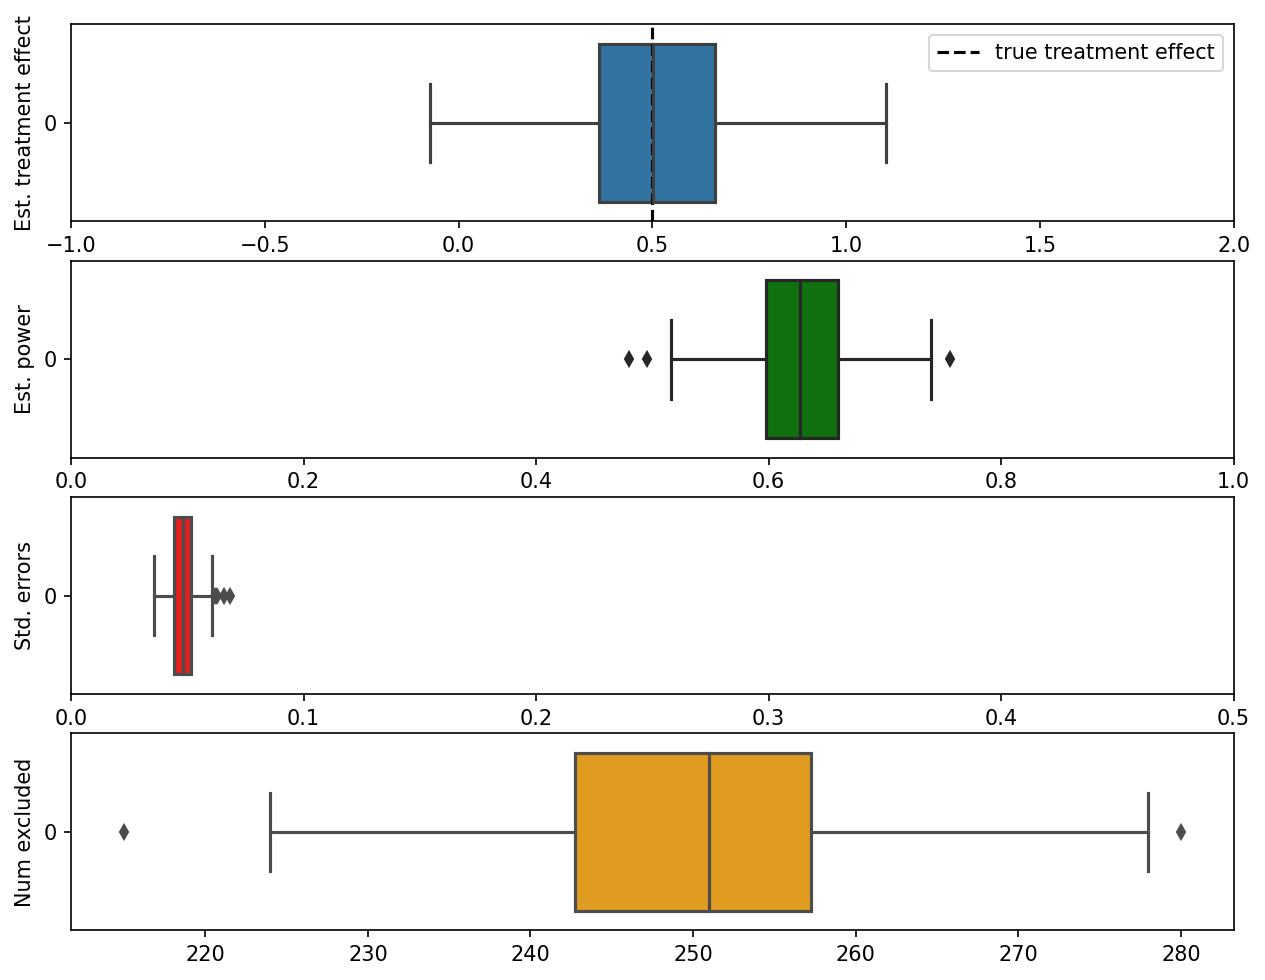

In [35]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "comply")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.7972675837705235
CPU times: user 1min 52s, sys: 3.47 s, total: 1min 56s
Wall time: 14.5 s


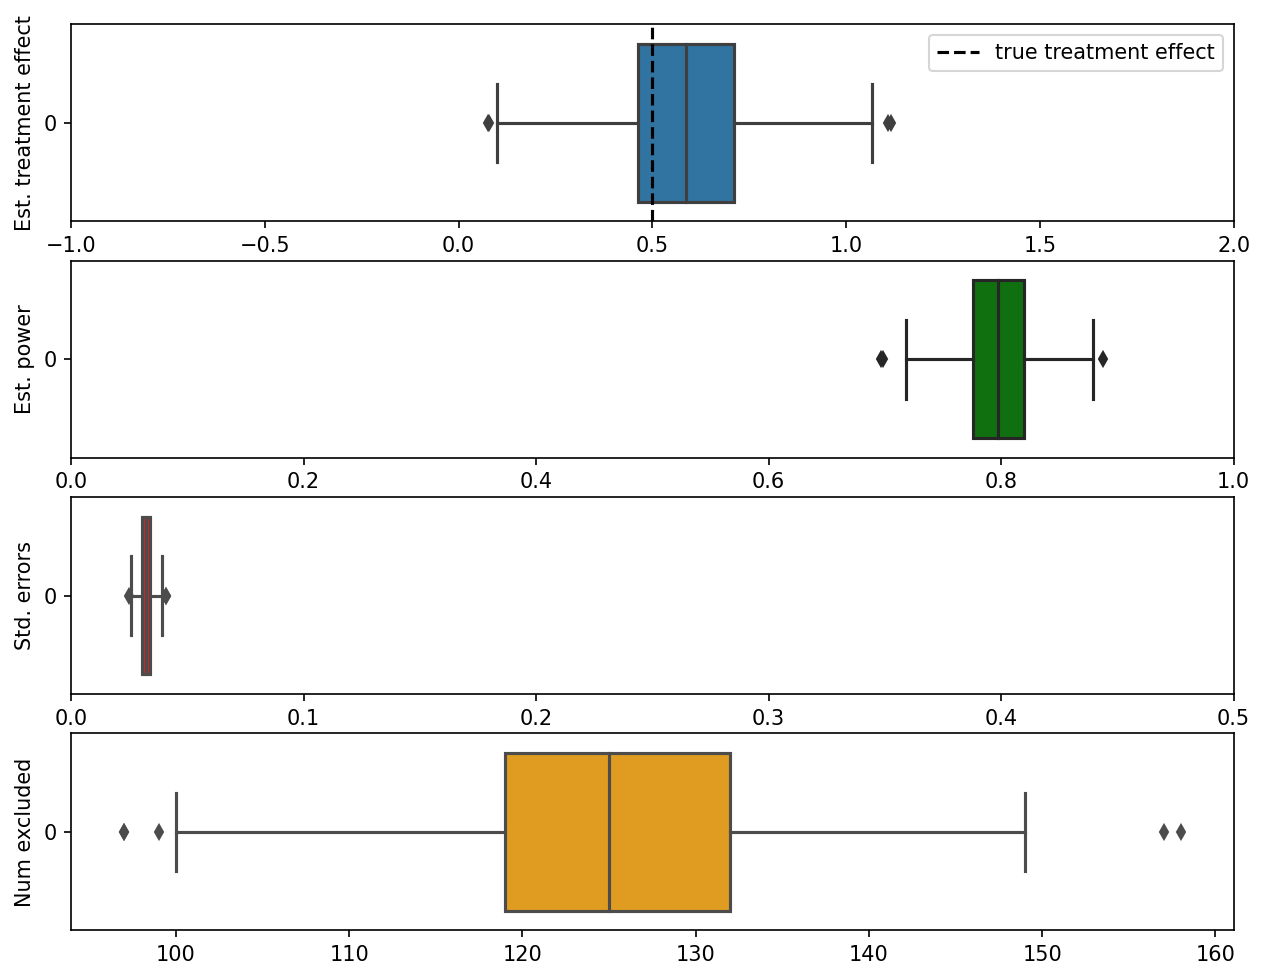

In [36]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, "TneqZ")

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

0.36324685405498247
CPU times: user 1min 46s, sys: 3.47 s, total: 1min 50s
Wall time: 13.8 s


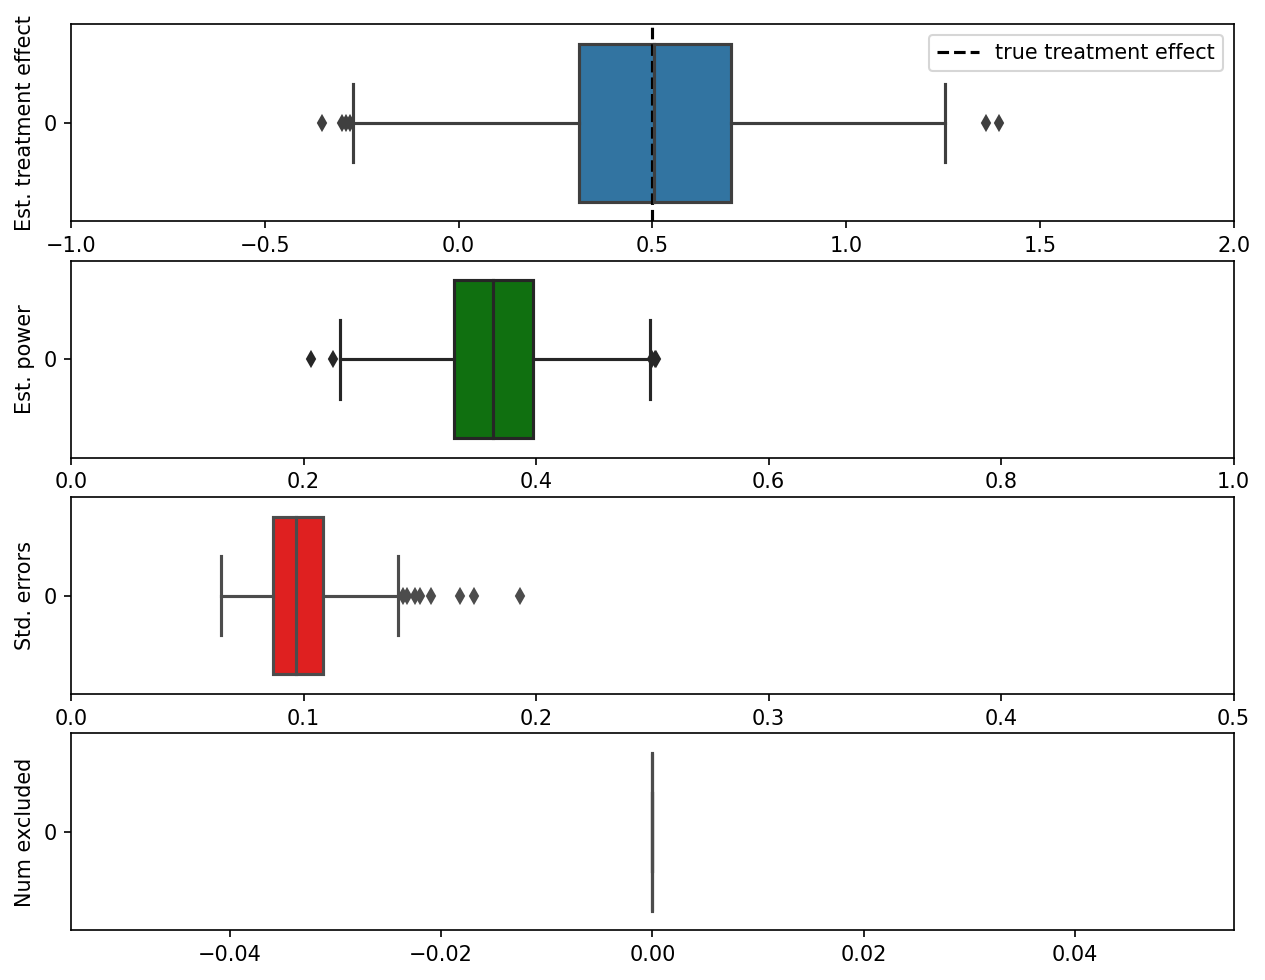

In [37]:
%%time

tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, None)

plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
print(np.mean(pwrs))

## Widget TODO revise

In [415]:
pd.set_option("display.precision", 3)

In [416]:
import warnings
warnings.filterwarnings('ignore')

@interact_manual(
    excl_type = [
        ("No exclusion", None),
        ("Per-protocol: T neq Z", "TneqZ"),
        ("True noncompliers", "comply")
    ],
    n=(100,1000,50),
    n_trials=(100,1000,50),
    prop_comply=(0,1, 0.1),
    tau=(-1, 1, 0.1),
    confound_str=(0, 1, 0.1)
)
def sim_plot_iv_exclusion(excl_type, n=500, n_trials=500, prop_comply=0.5, tau=0.5, confound_str=0.8):
    tau_hats, pwrs, var_hats, n_exclude = simulation(n, tau, prop_comply, n_trials, excl_type, confound_str)
    df = pd.DataFrame()
    df['tau_hat'] = tau_hats
    df['var_hat'] = var_hats
    df['power'] = pwrs
    df['n_exclude'] = n_exclude
    plot_results(tau, tau_hats, pwrs, var_hats, n_exclude)
    display(df.describe().transpose())

interactive(children=(Dropdown(description='excl_type', options=(('No exclusion', None), ('Per-protocol: T neq…

**TODO** figure out why excluding the observed noncompliers *isn't* biasing estimates
- answer: "per-protocol" analyses (where we only analyze observed compliers) is generally biased, but only when there are confounders (see Chapter 23.9.2 of Imbens & Rubin)
- Next thing to figure out: why is the power increase minimal even in the presence of a perfect compliance indicator?

# Power graphs as a function of compliance exclusion

- **note**: lifted from `naci_iv_walkthrough.ipynb` from old repo.

## Run simulation

In [65]:
%%time

n_samples = 1000
num_trials = 100
tau = 0.5

n_exclude = np.arange(0,901, 50)

exclude_list = []
complier_pwr_list = []
hat_pwr_list = []
var_list = []
target_effect_list = []
trial_list = []
comply_list = []
tau_list = []

compliances = [0.2, 0.4, 0.6]

formula = 'Y ~ 1+ [T ~ Z]'
for i in range(num_trials):
    print(i)
    for p_compliance in compliances:
        #df = gen_fuzzy_rdd_unif(n_samples, tau, p_compliance, seed=i)
        #df = df.sort_values('p_compliance', ascending=False)
        p_at = (1 - p_compliance) / 2
        p_nt = (1 - p_compliance) / 2
        
        df = generate_IV_comply_indicator(seed=i, 
                                       n_samples=n_samples, 
                                       tau=tau,
                                       prop_at=p_at,
                                       prop_nt=p_nt)
        #df['comply_order'] = df['comply_status'].apply(comply_to_int)
        
        #df = df.sort_values('comply_order', ascending=False)
        df = df.sort_values('X', ascending=False)
        for excl in n_exclude:
            trial_list.append(i)
            exclude_list.append(excl)
            comply_list.append(p_compliance)
            
            sel_df = df.head(int(n_samples-excl))
            ctl = sel_df[sel_df['T'] == 0]
            effect = np.std(ctl['Y']) / 2
            target_effect_list.append(effect)
            
            iv_model = IV2SLS.from_formula(formula, sel_df)
            iv_results = iv_model.fit(cov_type='robust')
            var = iv_results.std_errors['T']**2
            tau_hat = iv_results.params['T']
            var_list.append(var)
            tau_list.append(tau_hat)
            
            pwr = rdd_power(tau, var)
            #pwr = iv_power(sel_df, tau)
            complier_pwr_list.append(pwr)
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/utility.py:208: RuntimeWarning: divide by zero encountered in true_divide
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/utility.py:208: RuntimeWarning: invalid value encountered in matmul
  return vecs @ np.diag(1 / np.sqrt(vals)) @ vecs.T
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/linearmodels/iv/model.py:579: RuntimeWarning: invalid value encountered in matmul
  q = vpmzv_sqinv @ (ex1.T @ ex1) @ vpmzv_sqinv


39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 11min 11s, sys: 21.1 s, total: 11min 32s
Wall time: 1min 26s


## Plot power curves

In [66]:
pwr_unif_df = pd.DataFrame()
pwr_unif_df['n_exclude'] = exclude_list
pwr_unif_df['trial'] = trial_list
pwr_unif_df['complier_pwr'] = complier_pwr_list
pwr_unif_df['frac_comply'] = comply_list
pwr_unif_df['fraction compliers'] = pwr_unif_df['frac_comply'] 

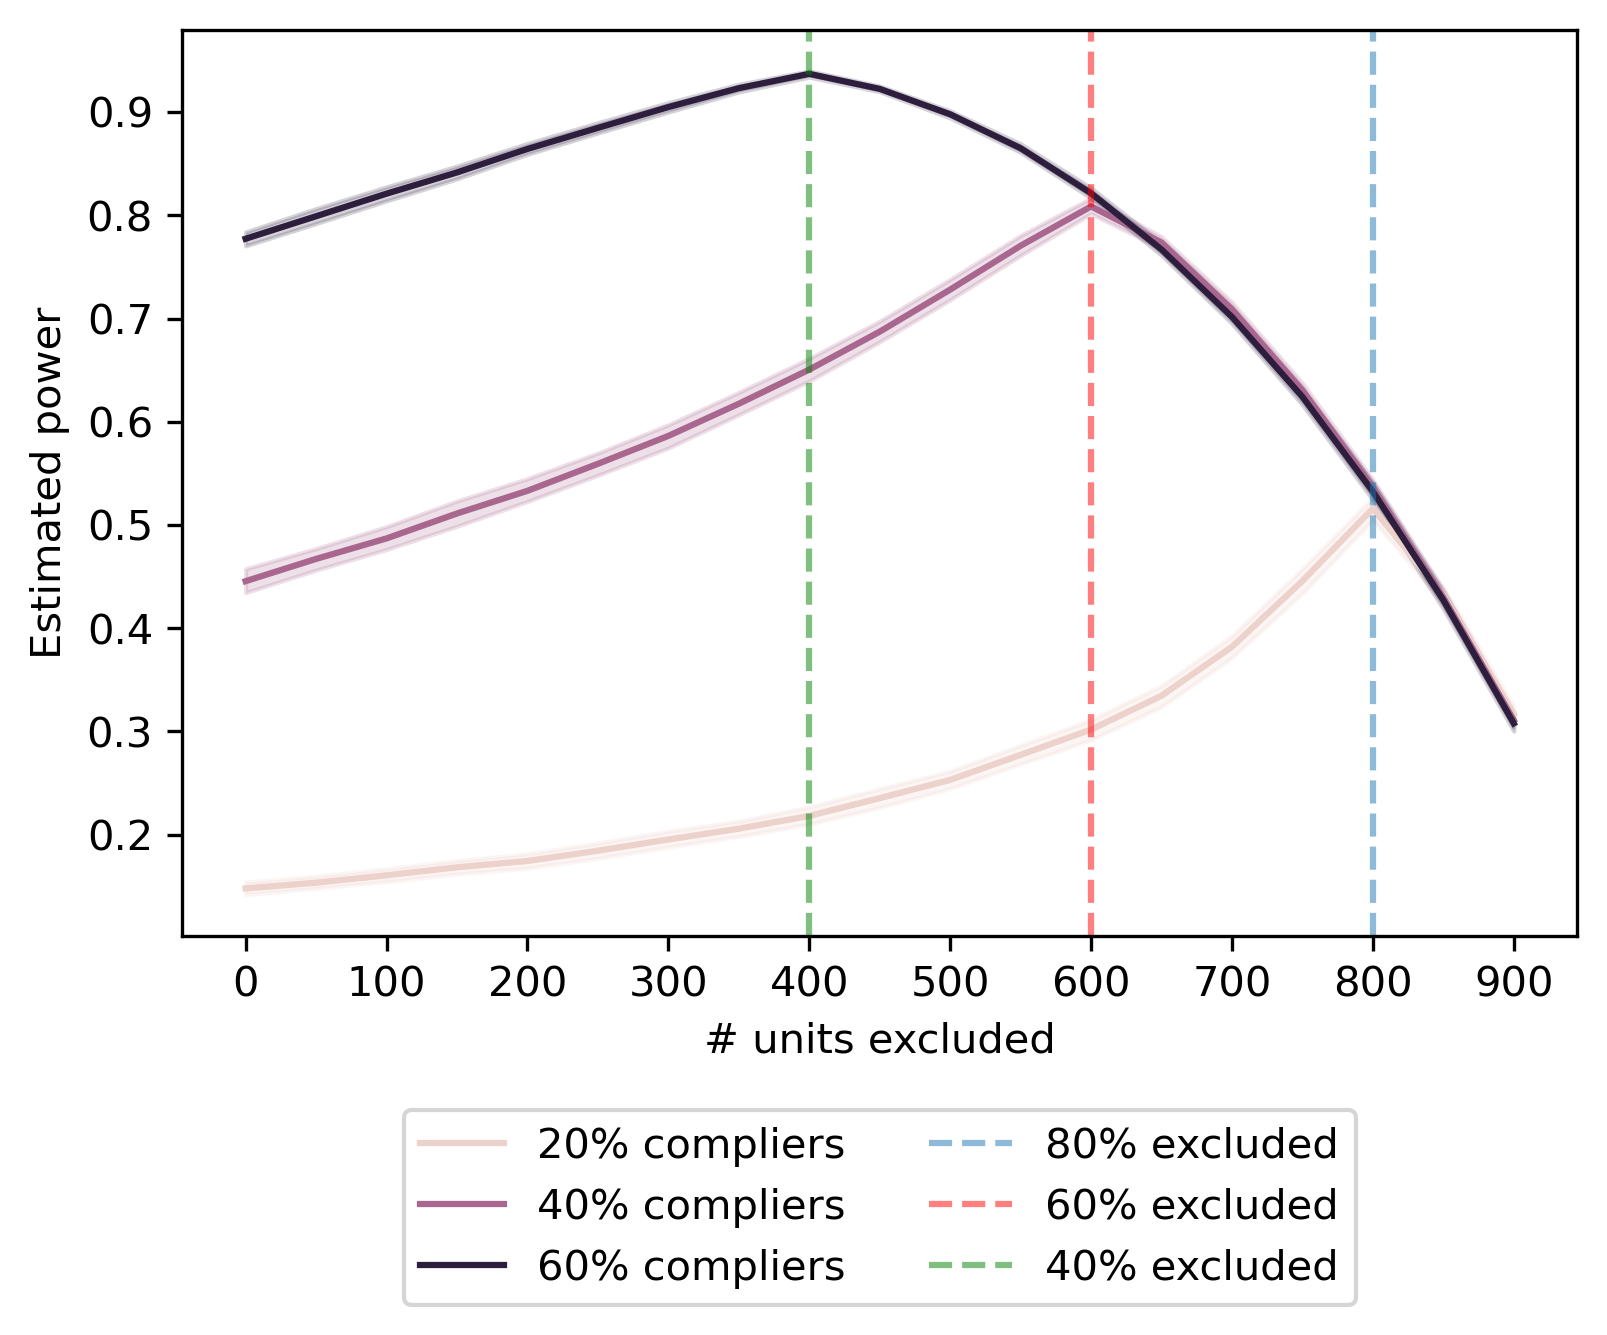

In [68]:
sns.lineplot(x='n_exclude', y='complier_pwr', data=pwr_unif_df, hue='fraction compliers', legend='full')
plt.axvline(x=800, label="80% excluded", ls='--', alpha=0.5)
plt.axvline(x=600, label="60% excluded", ls='--', color="r", alpha=0.5)
plt.axvline(x=400, label="40% excluded", ls='--', color='g', alpha=0.5)

plt.xticks(np.arange(0,1000,100))
legend = plt.legend(loc="center", ncol=2, bbox_to_anchor=(0.5, -0.3))
legend.get_texts()[0].set_text('20% compliers')
legend.get_texts()[1].set_text('40% compliers')
legend.get_texts()[2].set_text('60% compliers')
plt.ylabel("Estimated power")
plt.xlabel("# units excluded")

plt.savefig("../figures/pwr_known_comply.png", bbox_inches='tight')

# ML exploration

## Build simulated data

In [13]:
n = 2000
tau = 0.5
#prop_comply = 0.4
prop_at = 0.4
prop_nt = 0.4
prop_z = 0.8
seed = 42

data = generate_IV_comply_indicator(n_samples=n, 
                                    tau=tau, 
                                    seed=seed, 
                                    C_T=0.8, 
                                    prop_nt=prop_nt, 
                                    prop_at=prop_at, 
                                    prop_z=prop_z)
display(data.head())

,comply_coeff,comply_status,Z,X,T,C,Y,B
0,0.374540,nt,1,0,0,1.498166,-0.027406,0.25
1,0.950714,co,1,1,1,-1.612906,-2.267070,0.00
2,0.731994,at,0,0,1,-1.059541,0.545661,0.25
3,0.598658,at,0,0,1,3.497328,4.511618,0.25
4,0.156019,nt,0,0,0,-0.339402,0.974380,0.25


In [14]:
data['comply_indicator'] = data['T'] == data['Z'] 

## Split data

- **note**: the stratified split is on the "known compliance" indicator, so may be imbalanced for the true target $T$

In [16]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(data, y=data['comply_indicator']):
    indices.append(test_idx)
    

s1_df = data.iloc[indices[0]].copy()
s2_df = data.iloc[indices[1]].copy()


## Linear model of likely compliance

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [17]:
lr_model = LogisticRegression()
lr_model.fit(s1_df[['X']], s1_df['comply_indicator'])
print(lr_model.score(s1_df[['X']], s1_df['comply_indicator']))
print(lr_model.score(s2_df[['X']], s2_df['comply_indicator']))

0.6
0.601


In [18]:
s1_df[s1_df['X'] == 0]['comply_indicator'].value_counts()

False    400
True     395
Name: comply_indicator, dtype: int64

In [19]:
lr_preds = lr_model.predict_proba(s2_df[['X']])[:, 1]

- likely compliance prediction will predict p(likely compliance) == 1 for X=1, then E(likely compliance | X = 0) 

## RPy2 causal forest on heterogeneous instrument effects

In [665]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, r

In [666]:
pandas2ri.activate()
r_grf = importr('grf')
r_utils = importr('utils')

In [667]:
r_forest = r_grf.causal_forest(
    # grf expects a matrix for X, vectors for W, Y
    X = s1_df[['X']],
    W = s1_df['Z'],
    Y = s1_df['T'],
)

In [668]:
# predicted heterogeneous instrument effects
comp_hat = r.predict(r_forest, s2_df[['X']])

In [669]:
comp_hat.columns = ['cf_preds']
comp_hat['lr_preds'] = lr_preds

In [670]:
comp_hat

,cf_preds,lr_preds
1,1.000,0.988
2,1.000,0.988
3,1.000,0.988
4,-0.031,0.358
5,-0.031,0.358
...,...,...
996,1.000,0.988
997,1.000,0.988
998,-0.031,0.358
999,-0.031,0.358


## Back of the envelope checking of closed form solution for likely compliance

- p_nt = 0.12
- p_at = 0.48
- p_co = 0.4

In [671]:
data[(data['Z'] == 0) & (data['X'] == 0)]['T'].mean()

0.19393939393939394

In [672]:
data[(data['Z'] == 1) & (data['X'] == 0)]['T'].mean()

0.19696969696969696

In [673]:
test = data[data['X'] == 0]
test = test[test['Z'] == 1]
(test['Z'] == test['T']).sum()

169

In [674]:
p_at = data[(data['Z'] == 0) & (data['T'] == 1)].shape[0] / data[data['Z'] == 0].shape[0]
p_at

0.11130434782608696

In [676]:
p_nt = data[(data['Z'] == 1) & (data['T'] == 0)].shape[0] / data[data['Z'] == 1].shape[0]
p_nt

0.48350877192982455

In [677]:
1 - p_at - p_nt

0.40518688024408844

In [678]:
data[data['X'] == 1]['T'].mean()

0.6982758620689655

In [679]:
test = data[data['X'] == 1]

(test['Z'] == 1).sum()

567

In [682]:
(p_nt + prop_z*(p_at - p_nt)) / (p_nt + p_at)

0.31227494229289554

In [683]:
nt = .48
at = 0.12
co = 1 - nt - at
p = prop_z
(nt + p*(at - nt)) / (1 - co)

0.32

## EconML causal forest on heterogeneous instrument effects

In [24]:
# default params
cforest = CausalForestDML()

cforest.fit(Y=s1_df['T'],
            T=s1_df['Z'],
            X=s1_df['X'].values.reshape(-1,1))

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

In [26]:
# predicted heterogeneous instrument effects
comp_hat = cforest.effect(s2_df[['X']])

In [28]:
comp_df = pd.DataFrame()

comp_df['cf_preds'] = comp_hat
comp_df['lr_preds'] = lr_preds

In [30]:
comp_df.head(20)

,cf_preds,lr_preds
0,-0.022841,0.501797
1,1.000057,0.980838
2,-0.022841,0.501797
3,-0.022841,0.501797
4,-0.022841,0.501797
5,1.000057,0.980838
6,-0.022841,0.501797
7,-0.022841,0.501797
8,-0.022841,0.501797
9,1.000057,0.980838


# Compliance prediction with covariates and causal forests

## 1. generate data and check initial IV model

In [553]:
%%time

tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=5, noise=0, n_features=n_feats)

taus = []
formula = 'Y ~ 1  + [T ~ Z]'
for i in range(100):    
    iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=i)
    iv_model = IV2SLS.from_formula(formula, iv_df)
    iv_results = iv_model.fit(cov_type='robust')
    taus.append(iv_results.params['T'])

CPU times: user 2min 47s, sys: 4.35 s, total: 2min 51s
Wall time: 34.6 s


In [554]:
np.mean(taus)

In [555]:
iv_model = IV2SLS.from_formula(formula, iv_df)
iv_results = iv_model.fit(cov_type='robust')
display(iv_results)
print("estimated power for full data with simple 2SLS: {}".format(rdd_power(tau,iv_results.std_errors['T']**2)))


#print("estimated power for full data with simple 2SLS: {}".format(iv_power(iv_df, tau)))

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0107
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0103
No. Observations:                2000   F-statistic:                    2.2785
Date:                Sat, Oct 02 2021   P-value (F-stat)                0.1312
Time:                        20:18:21   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0301     0.0976     0.3085     0.7577     -0.1612      0.2214
T              0.2718     0.1800     1.5095     0.1312     -0.0811      0.6246
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f4052d7f110

estimated power for full data with simple 2SLS: 0.2842977450082792


### TSLS with covariates

In [556]:
feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [557]:
extended_formula = 'Y ~ 1 + ' 
extended_formula += ' + '.join(feat_cols)
extended_formula += ' + [T ~ Z]'

In [558]:
iv_df

,feat_0,feat_1,feat_2,feat_3,feat_4,comply_coeff,comply_status,Z,X,T,C,Y,B
0,0.182407,1.222208,-1.544152,-0.835578,0.289742,0.427851,at,1,0,1,-0.121740,1.737040,0.25
1,1.221775,-0.253143,1.030447,-2.425714,0.270484,0.494214,at,1,0,1,-1.778325,-0.730803,0.25
2,-0.405958,0.190432,-0.067165,-0.960765,-0.507418,0.373048,nt,1,0,0,-0.803695,-0.951514,0.25
3,1.006009,1.492557,-1.325067,0.666582,0.962806,0.587617,co,1,1,1,-1.272882,-1.291139,0.00
4,0.194679,-2.185607,-1.276007,-0.428527,0.620515,0.370958,nt,1,0,0,2.314337,1.378301,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-3.357397,0.289264,0.742493,0.190034,-0.205405,0.484018,at,0,0,1,4.187140,5.767481,0.25
1996,0.316293,2.240355,-2.534820,-0.978053,0.620885,0.442487,at,0,0,1,-0.712970,-0.511277,0.25
1997,-0.041062,0.778722,-0.143430,-0.894982,-0.077190,0.450156,at,0,0,1,-0.895917,0.647222,0.25
1998,0.270493,0.456201,0.023500,-0.167049,0.685398,0.570361,co,0,1,0,-0.755113,0.553320,0.00


In [559]:
iv_model = IV2SLS.from_formula(extended_formula, iv_df)
iv_results = iv_model.fit(cov_type='robust')
display(iv_results)
print("estimated power for full data with cov adjust 2SLS: {}".format(rdd_power(tau,iv_results.std_errors['T']**2)))

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0138
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0108
No. Observations:                2000   F-statistic:                    8.6643
Date:                Sat, Oct 02 2021   P-value (F-stat)                0.1934
Time:                        20:18:21   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0260     0.0991     0.2625     0.7930     -0.1683      0.2203
feat_0         0.0602     0.0397     1.5146     0.1299     -0.0177      0.1380
feat_1        -0.0282     0.0399    -0.7057     0.4804     -0.1064      0.0501
feat_2        -0.0158     0.0438    -0.3600     0.7189     -0.1016      0.0701
feat_3        -0.0567     0.0394    -1.4381     0.1504     -0.1340      0.0206
feat_4         0.0313     0.0470     0.6652     0.5059     -0.0609      0.1235
T              0.2872     0.1855     1.5479     0.1216     -0.0764      0.6509
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f409ee29450

estimated power for full data with cov adjust 2SLS: 0.2705397184620555


## 2. split the data

In [560]:
# s1_indices = np.random.choice(n_samples, size=int(n_samples/2), replace=False)

# s1_df = iv_df.iloc[s1_indices].copy()
# s2_df = iv_df.iloc[~s1_indices].copy()

In [561]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df, y=iv_df['T']):
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()


## 3. build compliance model

- use causal forests estimate compliance score

In [562]:
feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]
#feat_cols = ['X']

In [563]:

X = s1_df[feat_cols]
y = s1_df['T']
t = s1_df['Z']

In [564]:
%%time
# default params
cforest = CausalForestDML(discrete_treatment=True, cv=10)
#cforest = LinearDML(discrete_treatment=True, cv=10)

cforest.fit(Y=y,
            T=t,
            X=X)

pred_probas = cforest.effect(X)

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please

CPU times: user 12.9 s, sys: 278 ms, total: 13.2 s
Wall time: 1.91 s


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [565]:
s1_df['pred_comply'] = pred_probas

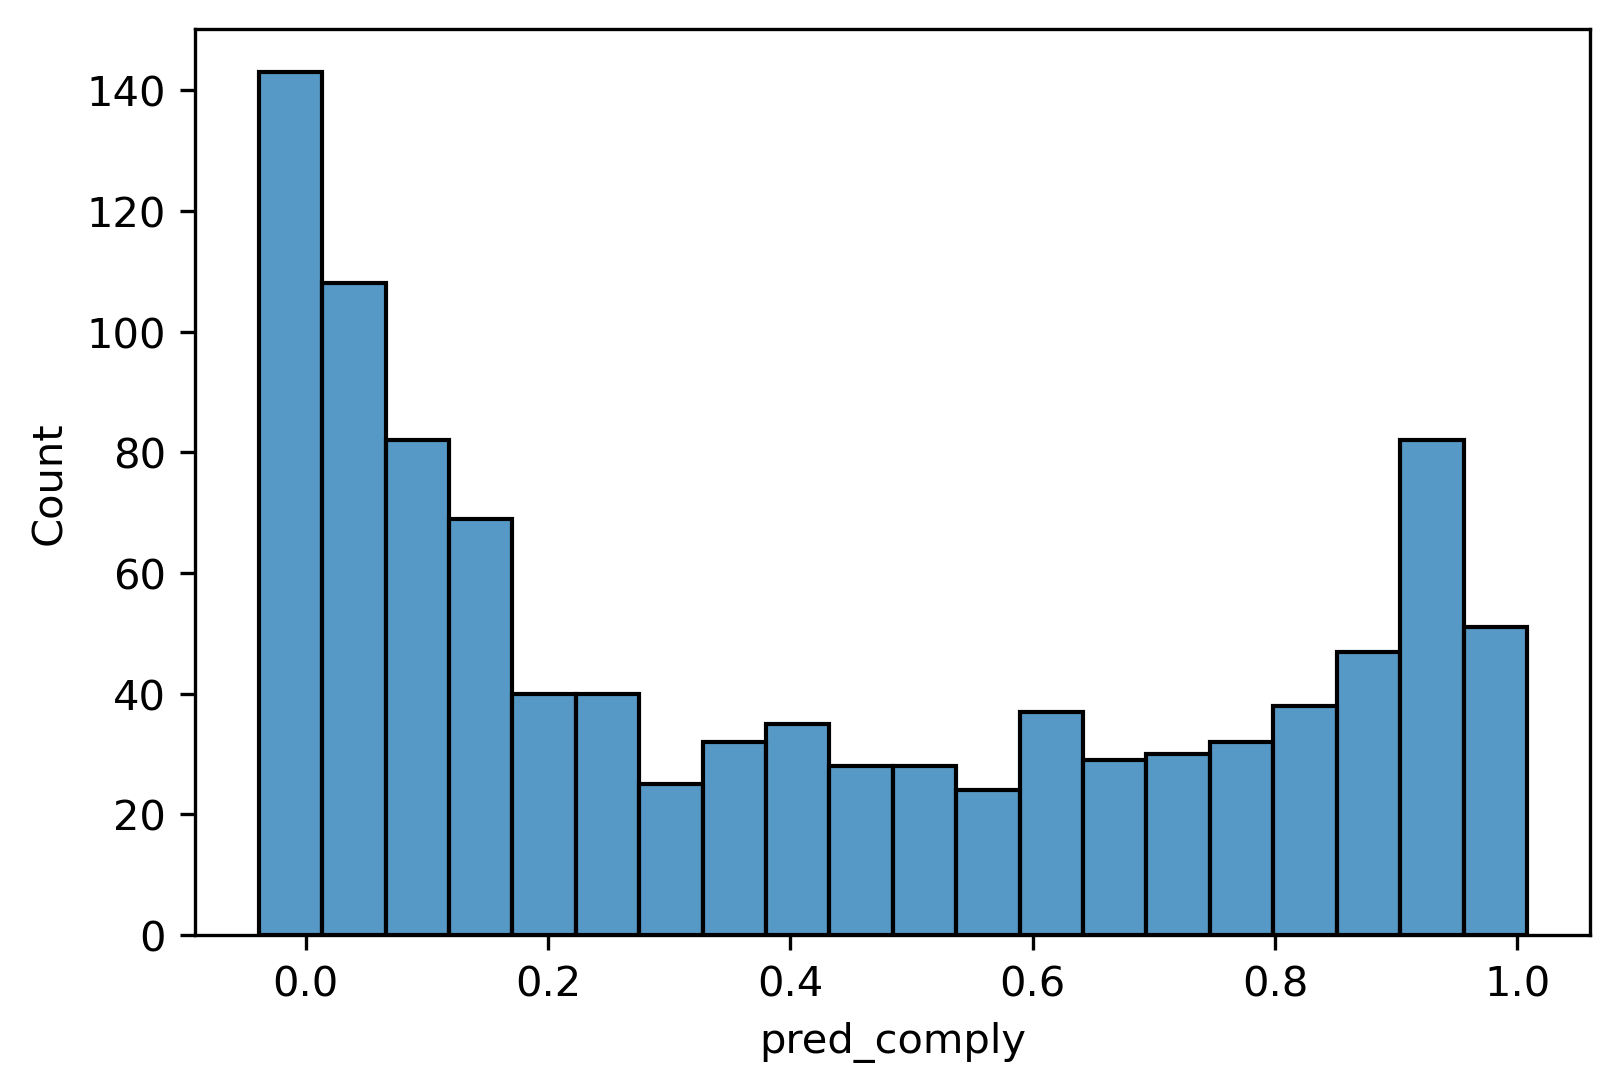

In [566]:
sns.histplot(s1_df['pred_comply'], bins=20)

### 4. find a threshold

Options: 

1. find threshold that maximizes statistical power of finding an effect
    - problem: can potentially exclude too many units
2. use a heuristic to estimate the number of non-compliers $n$ in the sample, exclude the $n$ samples with the lowest compliance scores

#### visualize power curve and threshold

In [488]:
def display_power_curve(fuzzy_df, tau, score, line=None):
    """
    Displays the power curve under our simplifying assumptions.
    
    fuzzy_df (pd.DataFrame): the dataframe
    tau (float): the target treatment effect for the power calculation
    score (str): the column in fuzzy_df to score against the threshold
    
    """
    try_thresholds = np.arange(0, 1, 0.05)
    actual_thresholds = []
    powers = []
    iv_vars = []
    for threshold in try_thresholds:
        sel_df = fuzzy_df[fuzzy_df[score] > threshold]
        #print(sel_df.shape[0])
        try:
            iv_model = IV2SLS.from_formula(formula, sel_df)
            iv_results = iv_model.fit(cov_type='robust')        
            iv_var = iv_results.std_errors['T']**2
            actual_thresholds.append(threshold)
            iv_vars.append(iv_var)
            powers.append(rdd_power(tau, iv_var))
        except Exception as e:
            print(e)
            print("Skipping {} threshold".format(threshold))
            
    sns.lineplot(x=actual_thresholds, y=powers, label="complier power")
    #sns.lineplot(x=thresholds, y=iv_vars, label="IV variance")
    if line:
        plt.axvline(x=line, label="chosen threshold", ls='--')
    plt.legend()
    

In [489]:
# threshold = 0.9

# sel_df = s1_df[s1_df['pred_comply'] > threshold]
# iv_model = IV2SLS.from_formula(formula, sel_df)
# iv_results = iv_model.fit(cov_type='robust')
# display(iv_results)
# print("estimated power: {}".format(rdd_power(tau,iv_results.std_errors['t']**2)))

divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in matmul


Text(0.5, 0, 'exclusion threshold for predicted compliance')

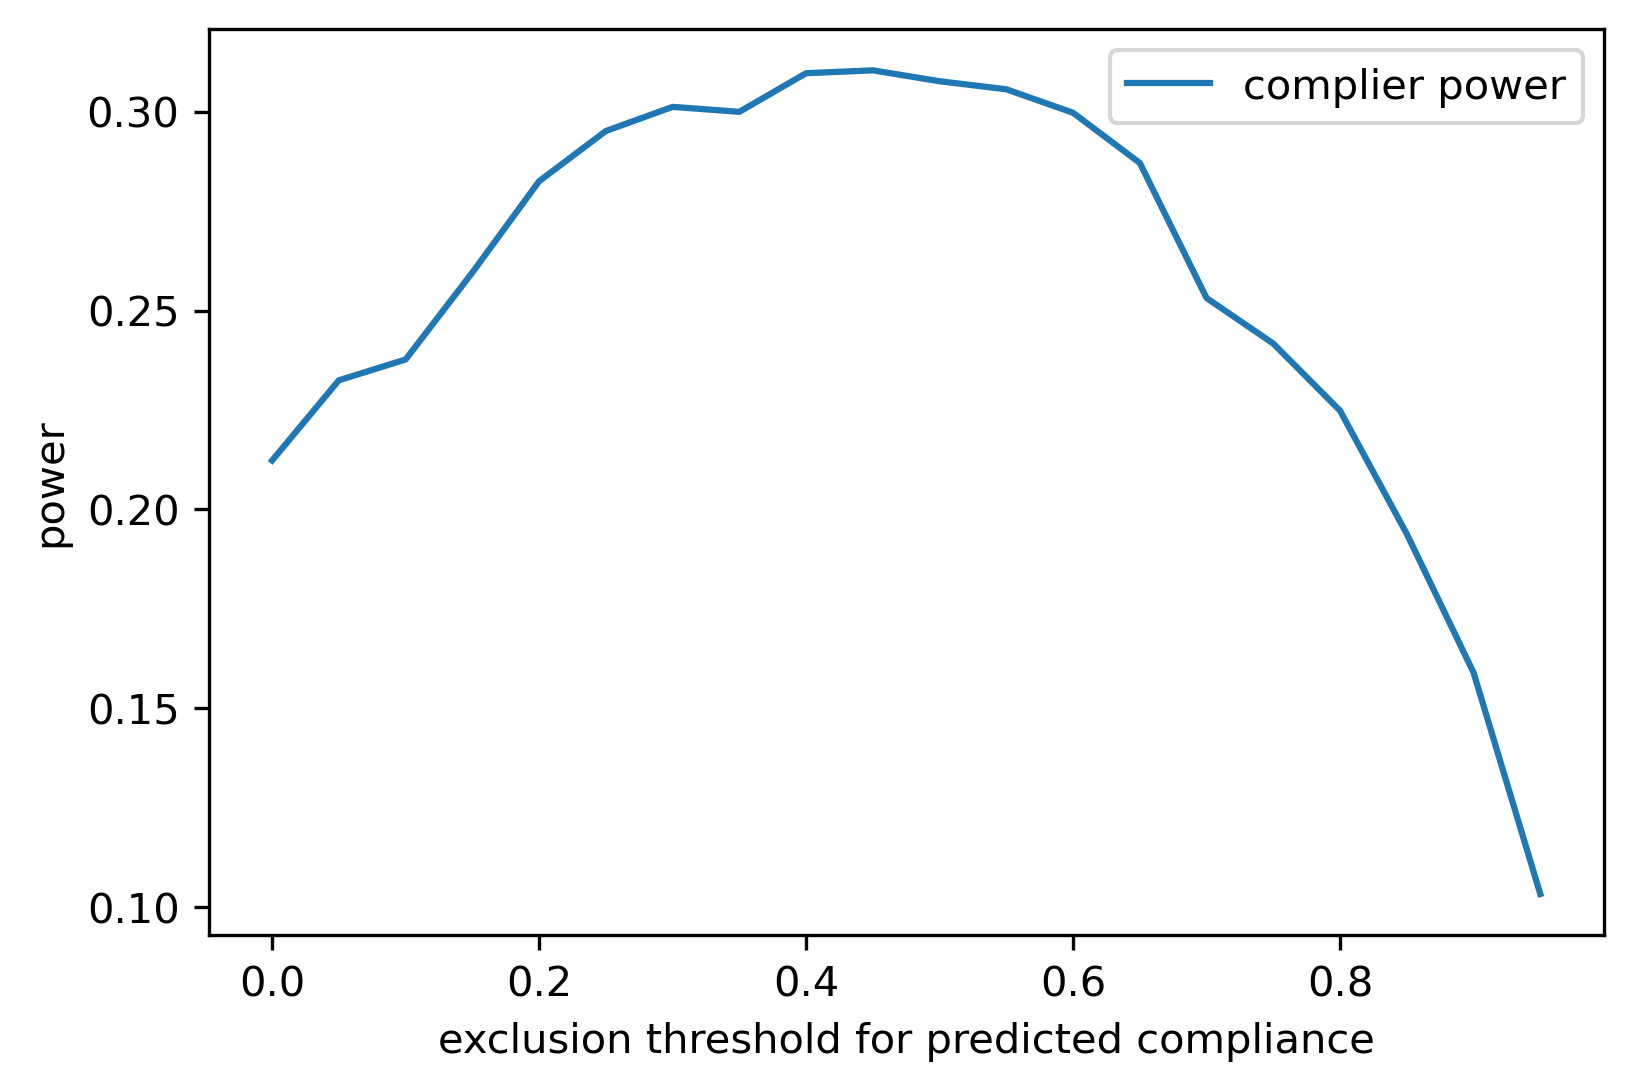

In [490]:
score = 'pred_comply'
display_power_curve(s1_df, tau=tau, score=score)
plt.ylabel("power")
plt.xlabel("exclusion threshold for predicted compliance")

#### convex optimization

In [491]:
def threshold_power(threshold, fuzzy_df, tau):
    """
    Computes the power for a given complier threshold and dataset.
    
    Args:
        threshold (float): the complier exclusion threshold
        fuzzy_df (pd.DataFrame): the data
        tau (float): the specified treatment effect for power calculation
    """
    sel_df = fuzzy_df[fuzzy_df['pred_comply'] > threshold]
    #print("threshold: {}, n_samples: {}".format(threshold, sel_df.shape[0]))
    
    try:
        iv_model = IV2SLS.from_formula(formula, sel_df)
        iv_results = iv_model.fit(cov_type='robust')        
        iv_var = iv_results.std_errors['T']**2
        
        return rdd_power(tau, iv_var)
    
    # if some exception is thrown
    except Exception as e:
        print(e)
        return -np.inf

In [492]:
from scipy.optimize import minimize_scalar

opt_result = minimize_scalar(lambda x: -1 * threshold_power(x, s1_df, tau), bounds=(0, 1), method='bounded', options=dict(maxiter=1000))
exclusion_threshold = opt_result.x
print(opt_result)

     fun: -0.31390663323241774
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 0.47640033564201256


#### sweep through all possible cutoffs

In [493]:
potential_thresholds = s1_df['pred_comply'].unique()
pairs = [(x,threshold_power(x, s1_df, tau)) for x in potential_thresholds]

regressors [exog endog] do not have full column rank


divide by zero encountered in true_divide
invalid value encountered in matmul
invalid value encountered in matmul
Mean of empty slice


zero-size array to reduction operation maximum which has no identity
regressors [exog endog] do not have full column rank


In [494]:
pairs.sort(key=lambda x: x[1])
exclusion_threshold = pairs[-1][0]
exclusion_threshold

### 5. test on other half of sample

In [567]:
#s2_preds = clf.predict_proba(s2_df[feat_cols])[:, 1]
s2_preds = cforest.effect(s2_df[feat_cols])

In [569]:
cforest.score(X=s2_df[feat_cols], Y=s2_df['T'], T=s2_df['Z'])

In [570]:
s2_df['pred_comply'] = s2_preds

In [571]:
s2_df[feat_cols + ['comply_status', 'pred_comply']].head(20)

,feat_0,feat_1,feat_2,feat_3,feat_4,comply_status,pred_comply
0,0.182407,1.222208,-1.544152,-0.835578,0.289742,at,0.249032
1,1.221775,-0.253143,1.030447,-2.425714,0.270484,at,0.679646
3,1.006009,1.492557,-1.325067,0.666582,0.962806,co,0.612258
6,-0.643418,-1.000564,-0.429005,0.579963,1.453622,co,0.873237
7,-0.621967,-1.086481,1.051630,0.443717,-0.941542,nt,0.098701
8,0.477009,1.472451,0.935863,1.854973,0.312753,co,0.790813
10,-0.297423,1.749565,-0.232845,2.571565,-1.059326,at,-0.004448
11,0.839050,0.051817,-0.709482,2.114736,-0.739903,at,0.018150
12,-2.325860,1.720098,0.032146,-1.720250,-1.137847,nt,-0.000589
14,0.832252,-0.923810,0.655762,-0.615178,0.131156,at,0.523435


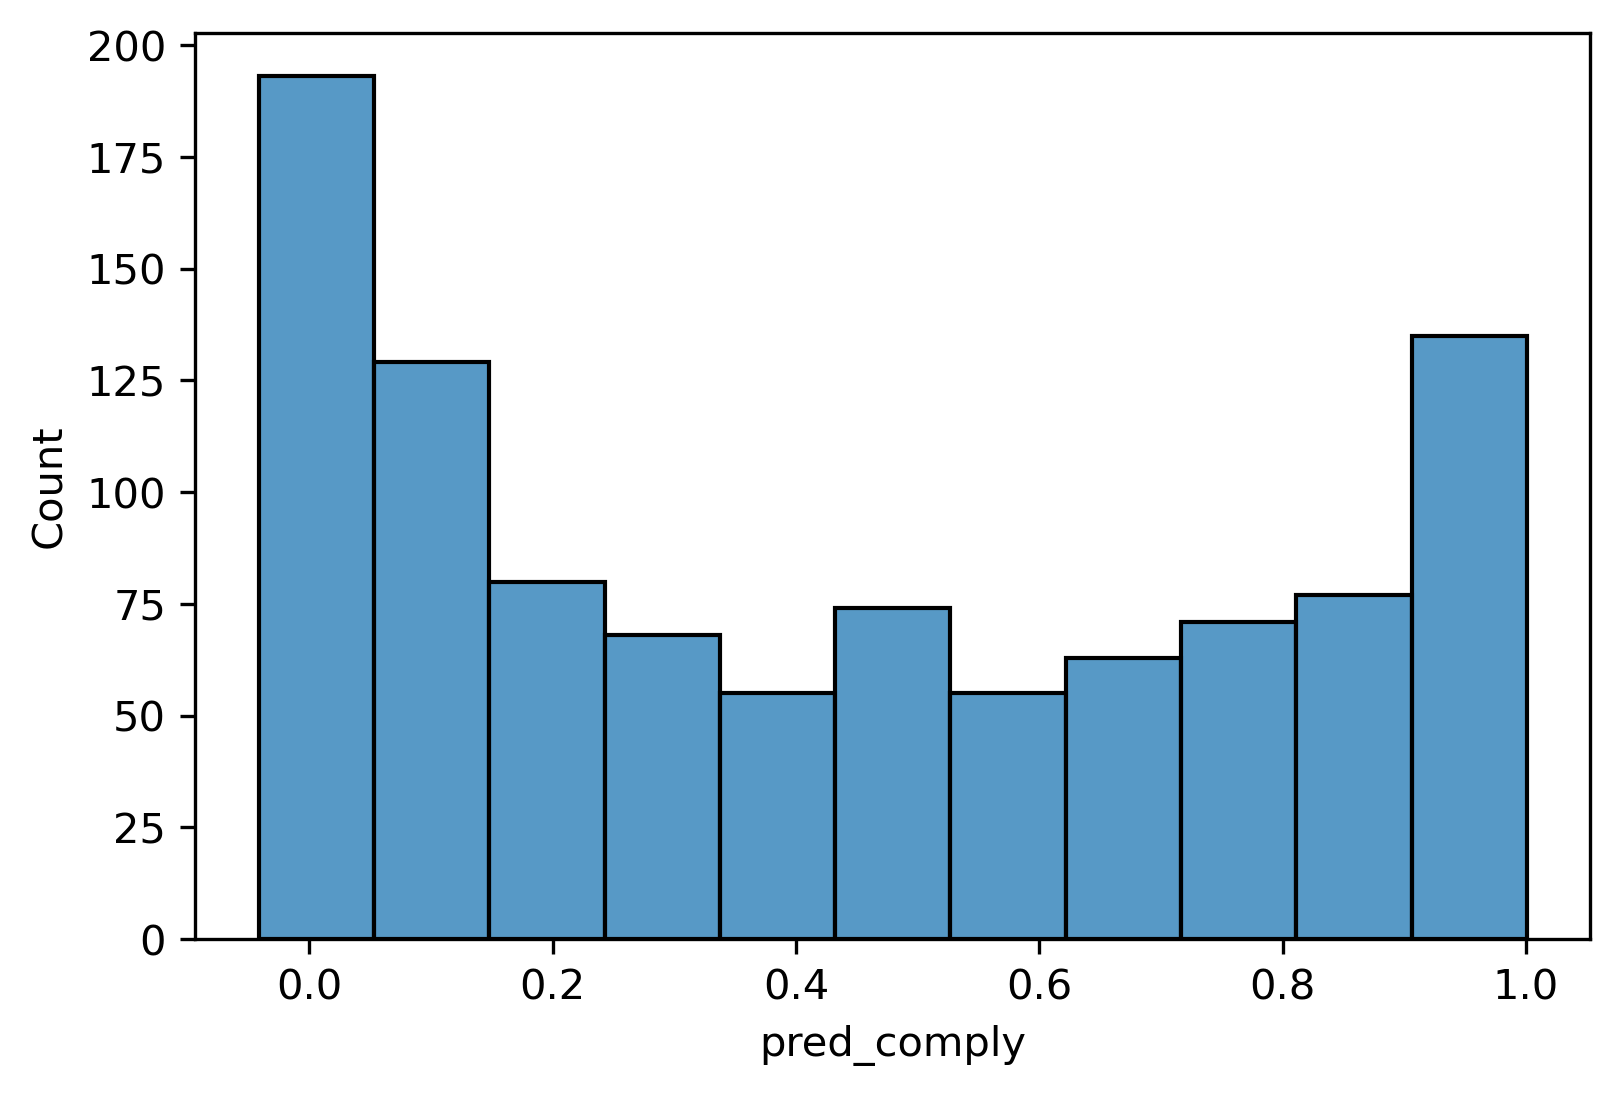

In [572]:
sns.histplot(s2_df['pred_comply'])

### Estimate fraction of compliers

In [573]:
prop_always = s1_df[(s1_df['Z'] == 0) & (s1_df['T'] == 1)].shape[0] / s1_df[s1_df['Z'] == 0].shape[0]
prop_always

In [574]:
prop_never = s1_df[(s1_df['Z'] == 1) & (s1_df['T'] == 0)].shape[0] / s1_df[s1_df['Z'] == 1].shape[0]
prop_never

In [575]:
est_frac_compliers = 1 - prop_always - prop_never

n_exclude = (1 - est_frac_compliers) * s2_df.shape[0]

preds = s2_df['pred_comply'].copy().values
preds.sort()

In [576]:
est_frac_compliers

In [577]:
exclusion_threshold = preds[int(n_exclude)]

Text(0.5, 0, 'exclusion threshold for predicted compliance')

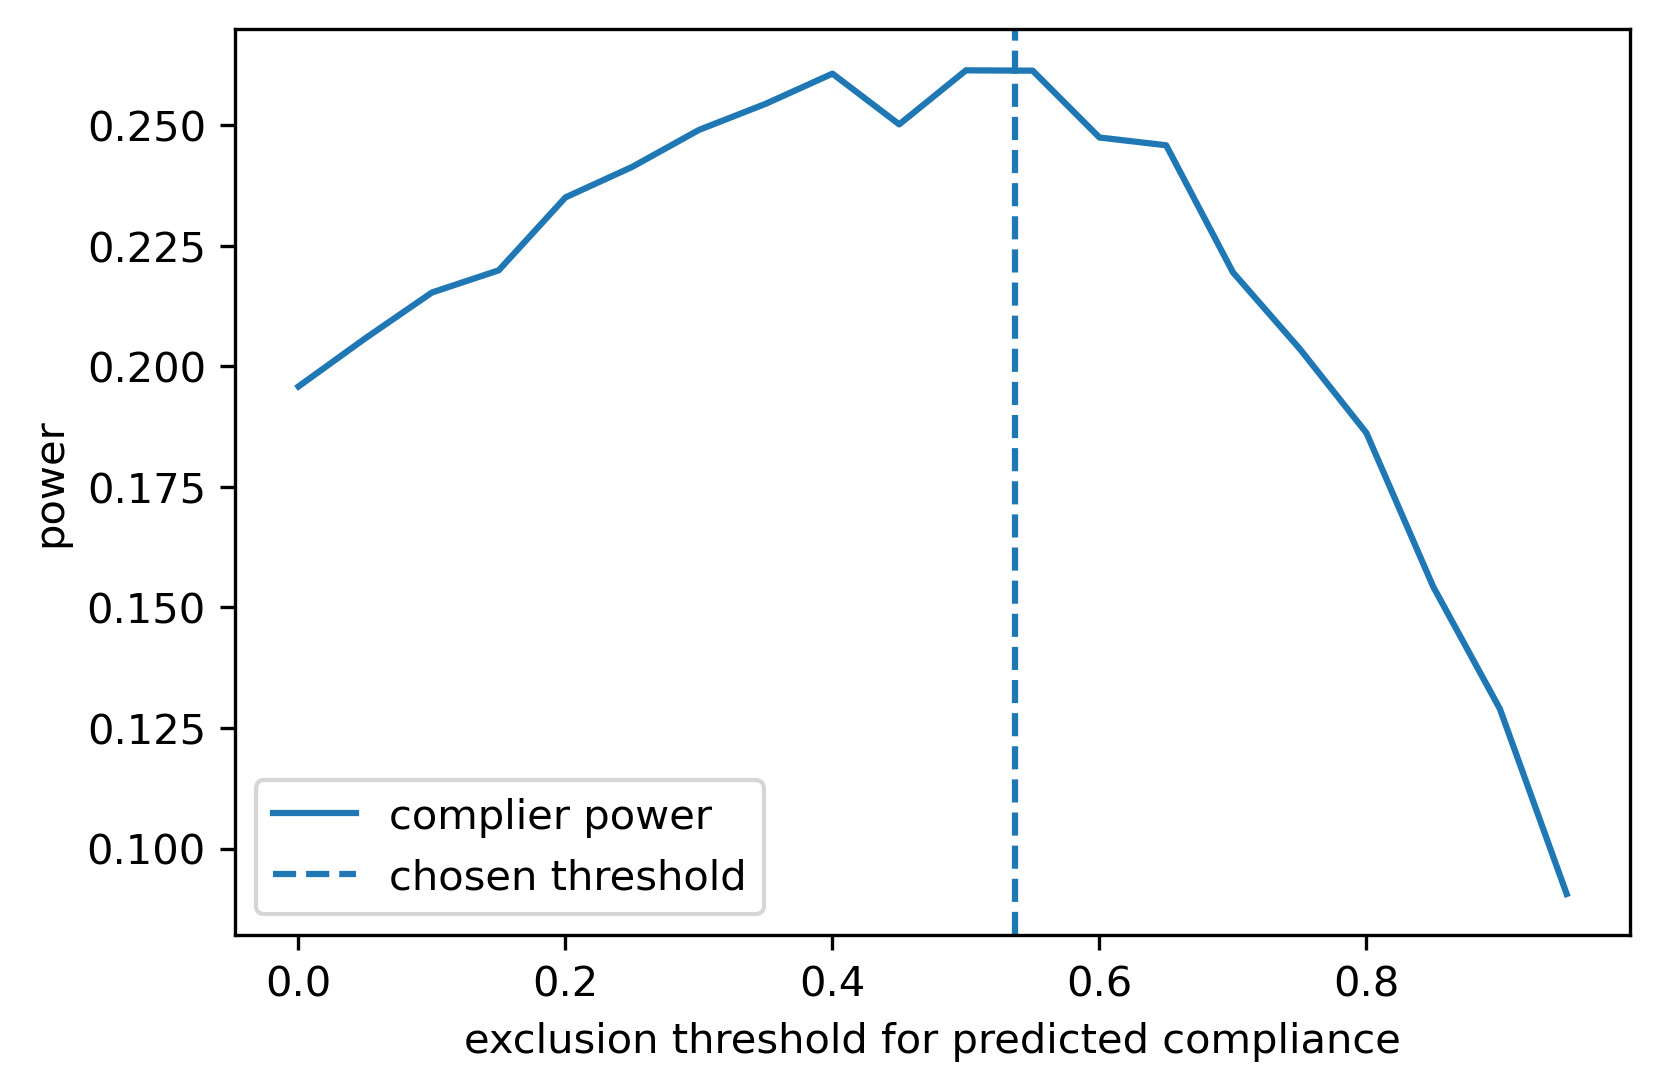

In [578]:
display_power_curve(s2_df, tau=tau, score="pred_comply", line=exclusion_threshold)
plt.ylabel("power")
plt.xlabel("exclusion threshold for predicted compliance")

In [579]:
s2_df.groupby('comply_status')['pred_comply'].describe()

,count,mean,std,min,25%,50%,75%,max
comply_status,,,,,,,,
at,288.0,0.304722,0.185767,-0.004448,0.165658,0.271134,0.436015,0.780687
co,429.0,0.757444,0.193969,0.069292,0.636727,0.809877,0.928037,1.000847
nt,283.0,0.051658,0.083966,-0.041663,-0.002347,0.029369,0.079223,0.496390


In [580]:
s1_df.groupby('comply_status')['pred_comply'].describe()

,count,mean,std,min,25%,50%,75%,max
comply_status,,,,,,,,
at,292.0,0.267016,0.163831,-0.029589,0.136231,0.234000,0.367687,0.811950
co,401.0,0.771311,0.185632,0.118429,0.645219,0.827450,0.931494,1.007781
nt,307.0,0.037992,0.066129,-0.038852,-0.007155,0.020773,0.063598,0.468052


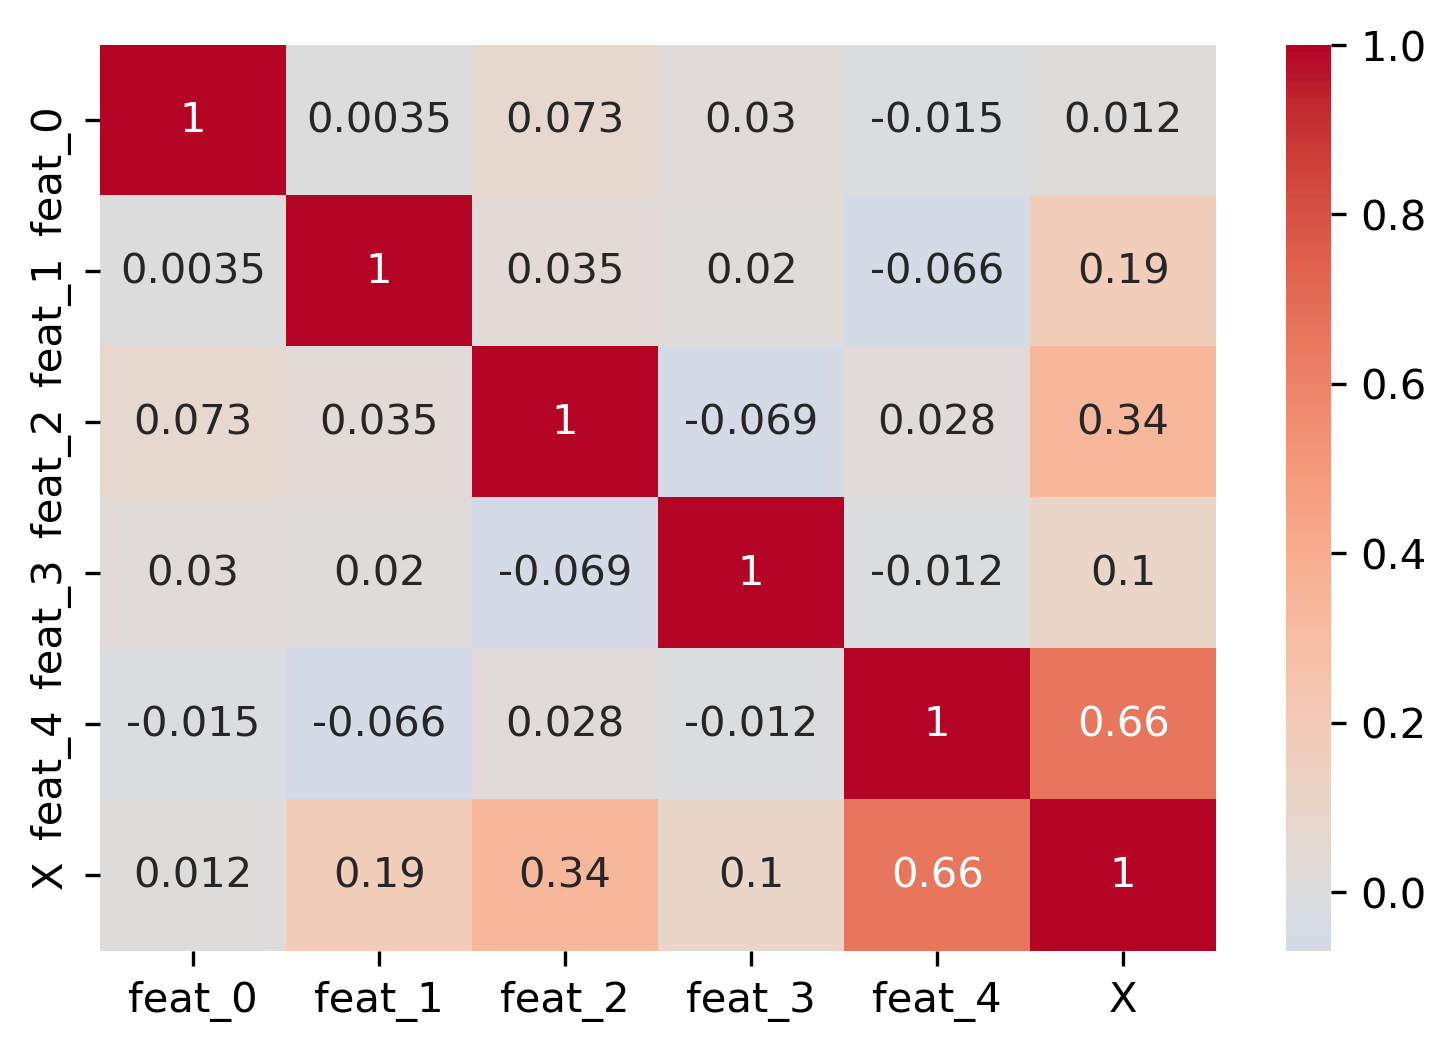

In [581]:
sns.heatmap(s2_df[feat_cols + ['X']].corr(), center=0, cmap='coolwarm', annot=True)

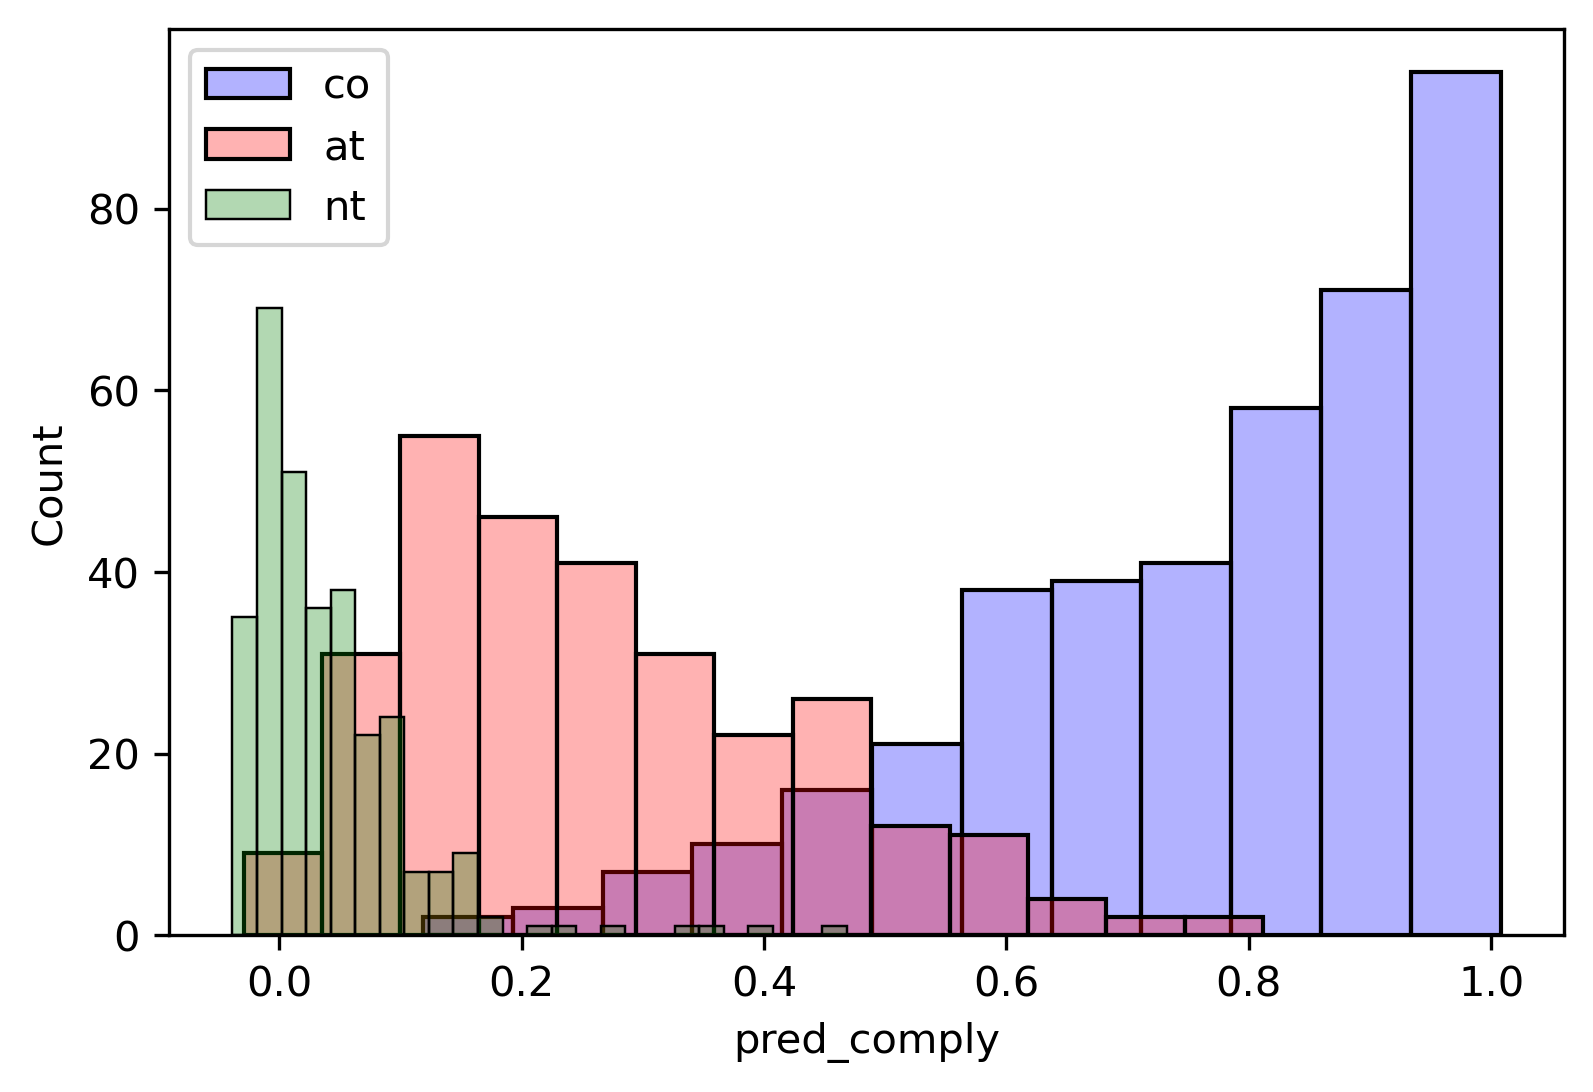

In [582]:
fig, ax = plt.subplots()

sns.histplot(s1_df[s1_df['comply_status'] == 'co']['pred_comply'], ax=ax, label='co', color='blue', alpha=0.3)
sns.histplot(s1_df[s1_df['comply_status'] == 'at']['pred_comply'], ax=ax, label='at', color='red', alpha=0.3)
sns.histplot(s1_df[s1_df['comply_status'] == 'nt']['pred_comply'], ax=ax, label='nt', color='green', alpha=0.3)

ax.legend()

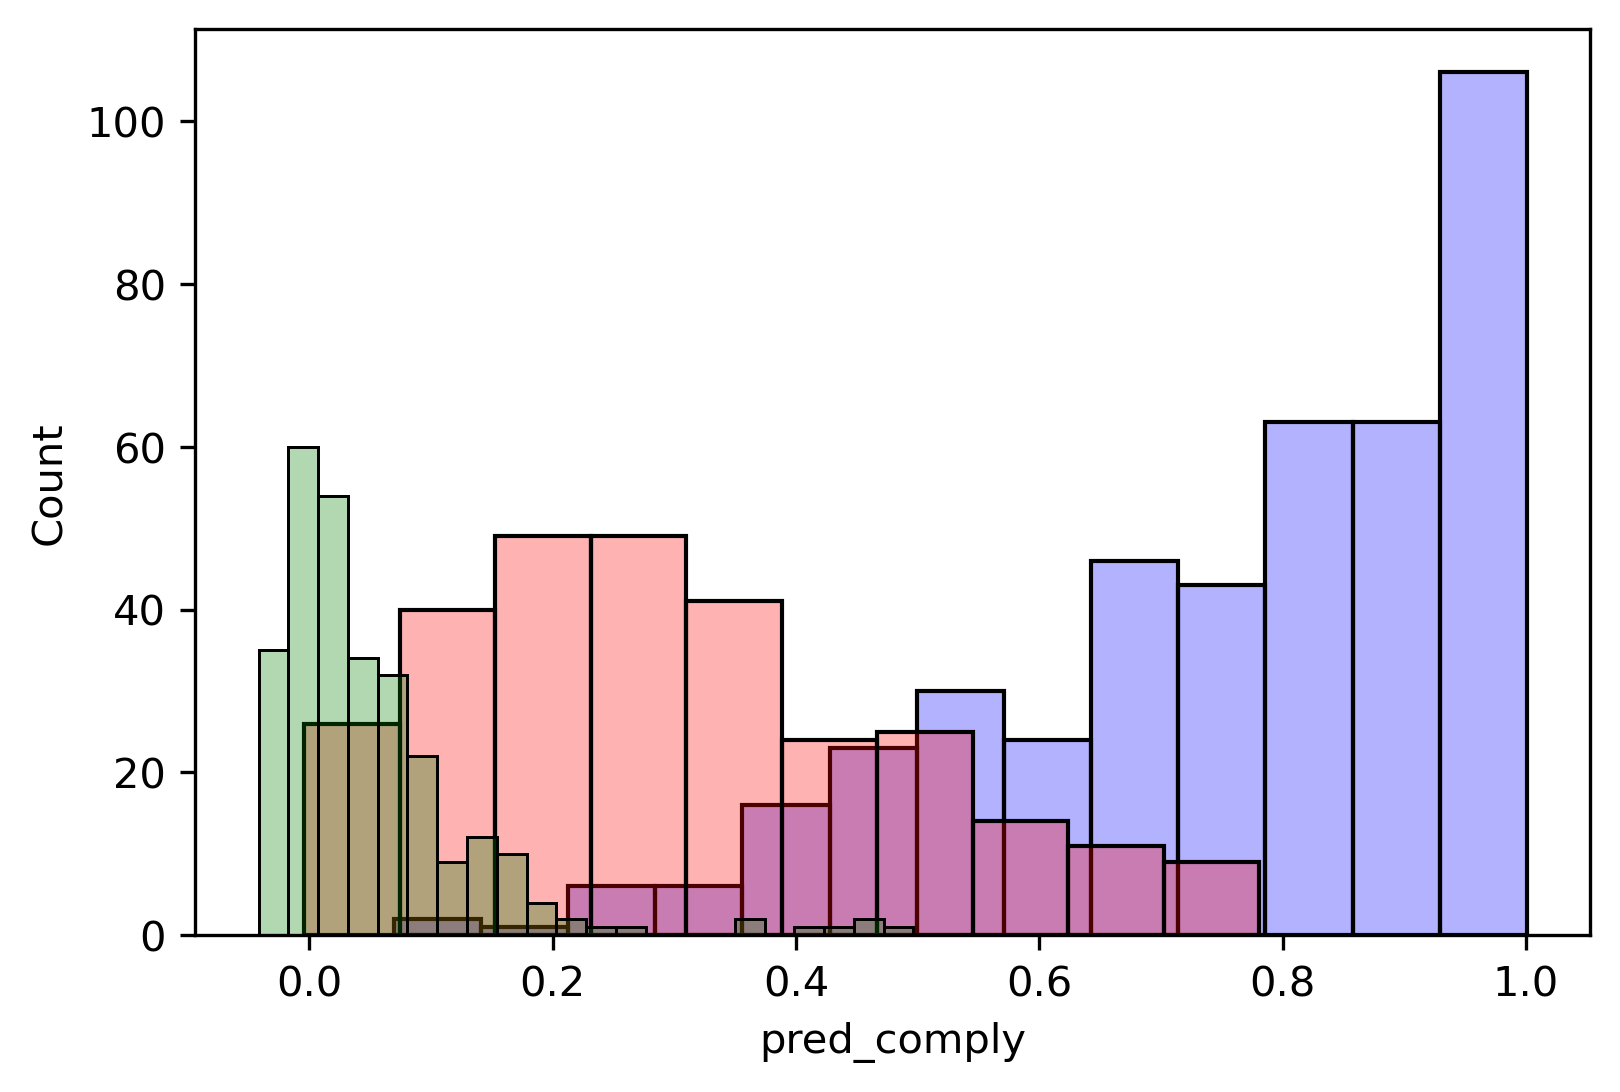

In [583]:
fig, ax = plt.subplots()

sns.histplot(s2_df[s2_df['comply_status'] == 'co']['pred_comply'], ax=ax, color='blue', alpha=0.3)
sns.histplot(s2_df[s2_df['comply_status'] == 'at']['pred_comply'], ax=ax, color='red', alpha=0.3)
sns.histplot(s2_df[s2_df['comply_status'] == 'nt']['pred_comply'], ax=ax, color='green', alpha=0.3)

In [585]:
sel_df = s2_df[s2_df['pred_comply'] > exclusion_threshold]
print("Selected {} samples".format(sel_df.shape[0]))
display(sel_df['comply_status'].value_counts() / sel_df.shape[0])
iv_model = IV2SLS.from_formula(formula, sel_df)
iv_results = iv_model.fit(cov_type='robust')
display(iv_results)
print("estimated power: {}".format(rdd_power(tau,iv_results.std_errors['T']**2)))
# print("estimated power: {}".format(iv_power(sel_df, 
#                                             tau)))

Selected 393 samples


co    0.910941
at    0.089059
Name: comply_status, dtype: float64

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0005
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0021
No. Observations:                 393   F-statistic:                    0.1647
Date:                Sat, Oct 02 2021   P-value (F-stat)                0.6848
Time:                        20:19:05   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.1666     0.1236     1.3474     0.1779     -0.0757      0.4089
T              0.0762     0.1878     0.4059     0.6848     -0.2919      0.4444
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f404b1f7510

estimated power: 0.2651399094374377


In [586]:
iv_results.params['T']

# Procedure simulation

In [651]:
def fit_predict_compliance(fit_df, pred_df, feat_cols, tau, seed=0, clf=None, use_optimizer=False, 
                           frac_exclude=None):
    """
    Fits a compliance model on fit_df and returns the predicted compliance scores, 
    as well as predicted threshold.
    
    Args:
        fit_df (pd.DataFrame): the dataframe to fit on
        pred_df (pd.DataFrame): the dataframe to generate prediction
        feat_cols (list): the list of feature columns to consider
        tau (float): the target treatment effect
        clf (model): an EconML CATE classifier, defaults to CausalForestDML if None provided
        use_optimizer (bool): whether or not to use scalar optimizer. Faster, but potential for non-convexity issues
        frac_exclude (float): optionally provide a fraction of individuals to exclude
    
    Returns:
        exclusion_threshold, acc, selected_df
    """
    
    
    fit_df = fit_df.copy()
    pred_df = pred_df.copy()
    
    X = fit_df[feat_cols]
    T = fit_df['Z']
    Y = fit_df['T']
    
    # fit on fit_df data
    if clf is None:
        clf = CausalForestDML(discrete_treatment=True,
                              cv=10, 
                              random_state=seed)
    
    clf.fit(Y=Y,
            T=T,
            X=X)

    fit_df['pred_comply'] = clf.effect(X)
    
    # predict on the pred_df data
    pred_probas = clf.effect(pred_df[feat_cols])
    
    acc = clf.score(X=pred_df[feat_cols], Y=pred_df['T'], T=pred_df['Z'])
    pred_df['pred_comply'] = pred_probas
    
    if use_optimizer:
        # use numerical optimization
        opt_result = minimize_scalar(lambda x: -1 * threshold_power(x, fit_df, tau), 
                                     bounds=(0, 1), 
                                     method='bounded', 
                                     options=dict(maxiter=1000))
        exclusion_threshold = opt_result.x
        
    elif frac_exclude:
        # only exclude a particular fraction of the individuals
        
        # estimate the number of always-takers and never-takers on the fitting data
        prop_always = fit_df[(fit_df['Z'] == 0) & (fit_df['T'] == 1)].shape[0] / fit_df[fit_df['Z'] == 0].shape[0]
        prop_never = fit_df[(fit_df['Z'] == 1) & (fit_df['T'] == 0)].shape[0] / fit_df[fit_df['Z'] == 1].shape[0]
        
        est_frac_compliers = 1 - prop_always - prop_never
        
        # exclude samples from prediction data
        n_exclude = (1 - est_frac_compliers) * frac_exclude * pred_df.shape[0]
        preds = pred_df['pred_comply'].copy().values
        preds.sort()
        
        exclusion_threshold = preds[int(n_exclude)]
        
    else:
        # sweep through potential thresholds, pick the threshold that maximizes power on the fitting data
        potential_thresholds = fit_df['pred_comply'].unique()
        pairs = [(x,threshold_power(x, fit_df, tau)) for x in potential_thresholds]
        pairs.sort(key=lambda x: x[1])
        exclusion_threshold = pairs[-1][0]    
        
    sel_df = pred_df[pred_df['pred_comply'] > exclusion_threshold]
    

    return exclusion_threshold, acc, sel_df


def populate_iv_results(df_dict, formula, data_df, tau, data_sample, acc=np.nan, threshold=np.nan):
    """
    Runs the 2SLS estimator and populates result_dict.
    
    Args:
        df_dict (dict)
        formulat (str): the patsy regression formula to use
        data_df (pd.DataFrame): the dataframe to run over
        tau (float): target treatment effect for power calculations
        data_sample (str): the name of the data sample
        acc (float): the test accuracy of the prediction, if applicable
        threshold (float): the complier threshold cutoff, if applicable
    
    Returns:
        None, but mutates result_dict
    """
    print("data_df shape:{}".format(data_df.shape[0]))
    iv_model = IV2SLS.from_formula(formula, data_df)
    iv_results = iv_model.fit(cov_type='robust')
    df_dict['tau_hat_{}'.format(data_sample)].append(iv_results.params['T'])
    df_dict['std_err_{}'.format(data_sample)].append(iv_results.std_errors['T'])
    df_dict['pwr_{}'.format(data_sample)].append(rdd_power(tau,iv_results.std_errors['T']**2))
    df_dict['n_incl_{}'.format(data_sample)].append(data_df.shape[0])
    df_dict['test_acc_{}'.format(data_sample)].append(acc)
    df_dict['threshold_{}'.format(data_sample)].append(threshold)
    

def simulate_optimal_exclusion(n_trials, clf=None, **kwargs):
    """
    Simulates optimal exclusion procedure with K=2 cross-fitting/sample splitting.
    
    Args:
        n_trials (int): number of trials to run
        clf (sklearn): the ML classifier to be using
        #iv_str (float): IV str, aka proportion of compliers
        kwargs: keyword arguments for gen_iv_with_comply_status
    
    Returns:
        df: a DataFrame containing:
            - trial
            - treatment effect estimate, std error, calculated power for:
                - full data simple 2SLS
                - full data 2SLS with covariates
                - s1 exclusion estimates
                - s2 exclusion estimates
            - s1, s2 number of included samples
            - s1, s2 compliance "test set" prediction accuracy
    """    
    print("true treatment effect: {}".format(kwargs['tau']))
    # initialize data dictionary    
    data_samples = ['full_simple', 'full_covar', 's1_simple', 's2_simple']
    vals = ['tau_hat', 'std_err', 'pwr', 'n_incl', 'test_acc', 'threshold']
    df_dict = { val + "_" + data: [] for val in vals for data in data_samples}
    df_dict['trial'] = []
    
    simple_formula = 'Y ~ 1 + [T ~ Z]'
    
    for trial in range(n_trials):
        fuzzy_df = generate_IV_comply_indicator(seed=trial, **kwargs)
        feat_cols = fuzzy_df.columns[fuzzy_df.columns.str.startswith("feat")].tolist()
        extended_formula = 'Y ~ 1 + {} + [T ~ Z]'.format(' + '.join(feat_cols))

        # simple model with full data
        populate_iv_results(df_dict, simple_formula, fuzzy_df, kwargs['tau'], 'full_simple')

        # covariate model with full data
        populate_iv_results(df_dict, extended_formula, fuzzy_df, kwargs['tau'], 'full_covar')
        
        # split sample, TODO think about whether we need to stratified split on T
        np.random.seed(trial)
        
        kfold = StratifiedKFold(n_splits=2,
             shuffle=True, random_state=trial)

        indices = []

        for train_idx, test_idx in kfold.split(fuzzy_df, y=fuzzy_df['T']):
            indices.append(test_idx)
    

        fit_df = fuzzy_df.iloc[indices[0]].copy()
        s2_df = fuzzy_df.iloc[indices[1]].copy()

        # fit on first half
        s1_threshold, s1_acc, s1_sel_df = fit_predict_compliance(fit_df, s2_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf,
                                                                 use_optimizer=False, frac_exclude=1)

        populate_iv_results(df_dict, extended_formula, s1_sel_df, kwargs['tau'], 's1_simple',
                            threshold=s1_threshold, acc=s1_acc)

        # fit on second half
        s2_threshold, s2_acc, s2_sel_df = fit_predict_compliance(s2_df, fit_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf,
                                                                 use_optimizer=False, frac_exclude=1)

        populate_iv_results(df_dict, extended_formula, s2_sel_df, kwargs['tau'], 's2_simple',
                            threshold=s2_threshold, acc=s2_acc)


        df_dict['trial'].append(trial)
        print("trial {}".format(trial))

    return pd.DataFrame.from_dict(df_dict)

In [663]:
%%time

import warnings

n_trials = 100

with warnings.catch_warnings():
    warnings.simplefilter('ignore')# DeprecationWarning)

    for prop_comply in [0.2, 0.4, 0.6]:
        p_at = (1 - prop_comply) / 2
        p_nt = (1 - prop_comply) / 2
        tau = 0.25
        sim_dict = dict(
                prop_at = p_at,
                prop_nt = p_nt,
                tau = tau, # true treatment effect
                n_samples = 1000,
                use_covars = True,
                # tunes how much the covariates influence compliance
                regression_dict = dict(n_informative=5, 
                                       noise=0, 
                                       n_features=5)

        )


        result_df = simulate_optimal_exclusion(n_trials, **sim_dict)

        result_df['data_driven_tau'] = (result_df['tau_hat_s1_simple'] + result_df['tau_hat_s2_simple']) / 2

        result_df['data_driven_var'] = ((result_df['std_err_s1_simple'] ** 2) + (result_df['std_err_s2_simple'] ** 2) + \
                                     (result_df['tau_hat_s1_simple'] - result_df['data_driven_tau'])**2 + \
                                     (result_df['tau_hat_s2_simple'] - result_df['data_driven_tau'])**2) / 2

        result_df['data_driven_std'] = np.sqrt(result_df['data_driven_var'])


        result_df['data_driven_pwr'] = result_df['data_driven_var'].apply(lambda x: rdd_power(tau, var=x))
        result_df['data_driven_n_incl'] = result_df['n_incl_s1_simple'] + result_df['n_incl_s2_simple']

        name = "../results/iv_data_driven_p_comply_{}.df".format(prop_comply)
        result_df.to_pickle(name)

true treatment effect: 0.25
data_df shape:1000
data_df shape:1000
data_df shape:64
data_df shape:102
trial 0
data_df shape:1000
data_df shape:1000
data_df shape:131
data_df shape:103
trial 1
data_df shape:1000
data_df shape:1000
data_df shape:112
data_df shape:84
trial 2
data_df shape:1000
data_df shape:1000
data_df shape:102
data_df shape:85
trial 3
data_df shape:1000
data_df shape:1000
data_df shape:107
data_df shape:111
trial 4
data_df shape:1000
data_df shape:1000
data_df shape:101
data_df shape:77
trial 5
data_df shape:1000
data_df shape:1000
data_df shape:107
data_df shape:113
trial 6
data_df shape:1000
data_df shape:1000
data_df shape:90
data_df shape:81
trial 7
data_df shape:1000
data_df shape:1000
data_df shape:113
data_df shape:109
trial 8
data_df shape:1000
data_df shape:1000
data_df shape:76
data_df shape:102
trial 9
data_df shape:1000
data_df shape:1000
data_df shape:123
data_df shape:146
trial 10
data_df shape:1000
data_df shape:1000
data_df shape:41
data_df shape:80
tria

data_df shape:115
trial 99
true treatment effect: 0.25
data_df shape:1000
data_df shape:1000
data_df shape:161
data_df shape:201
trial 0
data_df shape:1000
data_df shape:1000
data_df shape:177
data_df shape:206
trial 1
data_df shape:1000
data_df shape:1000
data_df shape:205
data_df shape:155
trial 2
data_df shape:1000
data_df shape:1000
data_df shape:214
data_df shape:199
trial 3
data_df shape:1000
data_df shape:1000
data_df shape:223
data_df shape:196
trial 4
data_df shape:1000
data_df shape:1000
data_df shape:168
data_df shape:182
trial 5
data_df shape:1000
data_df shape:1000
data_df shape:206
data_df shape:223
trial 6
data_df shape:1000
data_df shape:1000
data_df shape:156
data_df shape:203
trial 7
data_df shape:1000
data_df shape:1000
data_df shape:206
data_df shape:230
trial 8
data_df shape:1000
data_df shape:1000
data_df shape:196
data_df shape:209
trial 9
data_df shape:1000
data_df shape:1000
data_df shape:231
data_df shape:227
trial 10
data_df shape:1000
data_df shape:1000
data

data_df shape:281
data_df shape:290
trial 22
data_df shape:1000
data_df shape:1000
data_df shape:357
data_df shape:311
trial 23
data_df shape:1000
data_df shape:1000
data_df shape:310
data_df shape:291
trial 24
data_df shape:1000
data_df shape:1000
data_df shape:289
data_df shape:308
trial 25
data_df shape:1000
data_df shape:1000
data_df shape:320
data_df shape:312
trial 26
data_df shape:1000
data_df shape:1000
data_df shape:342
data_df shape:270
trial 27
data_df shape:1000
data_df shape:1000
data_df shape:316
data_df shape:262
trial 28
data_df shape:1000
data_df shape:1000
data_df shape:327
data_df shape:311
trial 29
data_df shape:1000
data_df shape:1000
data_df shape:314
data_df shape:329
trial 30
data_df shape:1000
data_df shape:1000
data_df shape:301
data_df shape:291
trial 31
data_df shape:1000
data_df shape:1000
data_df shape:296
data_df shape:307
trial 32
data_df shape:1000
data_df shape:1000
data_df shape:288
data_df shape:307
trial 33
data_df shape:1000
data_df shape:1000
data

In [675]:
pwr_cols = result_df.columns[result_df.columns.str.contains("pwr")]
std_cols = result_df.columns[result_df.columns.str.contains("std")]
tau_cols = result_df.columns[result_df.columns.str.contains("tau")]
acc_cols = result_df.columns[result_df.columns.str.contains("acc")]
n_cols = result_df.columns[result_df.columns.str.contains("incl")]
thres_cols = result_df.columns[result_df.columns.str.contains("thres")]

result_df[tau_cols].describe()
#result_df[result_df['tau_hat_s1_simple'] == result_df['tau_hat_s2_simple']]

,tau_hat_full_simple,tau_hat_full_covar,tau_hat_s1_simple,tau_hat_s2_simple,data_driven_tau
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.262326,0.260838,0.260173,0.262960,0.261567
std,0.168062,0.167923,0.229691,0.215050,0.153353
min,-0.089025,-0.085242,-0.194026,-0.226199,-0.125597
25%,0.136072,0.143465,0.098818,0.128073,0.142389
50%,0.234245,0.241708,0.271988,0.243048,0.259778
75%,0.392707,0.388472,0.408437,0.428942,0.376876
max,0.675491,0.685780,0.859480,0.730336,0.670934


In [676]:
result_df[pwr_cols].describe()

,pwr_full_simple,pwr_full_covar,pwr_s1_simple,pwr_s2_simple,data_driven_pwr
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.280027,0.280126,0.200472,0.200470,0.161496
std,0.019916,0.019629,0.015258,0.018578,0.032829
min,0.237827,0.233454,0.170223,0.164634,0.081536
25%,0.264025,0.266010,0.189634,0.185573,0.138362
50%,0.276082,0.275092,0.201502,0.199363,0.171845
75%,0.293330,0.293205,0.210693,0.212424,0.187135
max,0.329083,0.324072,0.231472,0.246435,0.213777


### Power distributions

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0, 0.5, 'count')

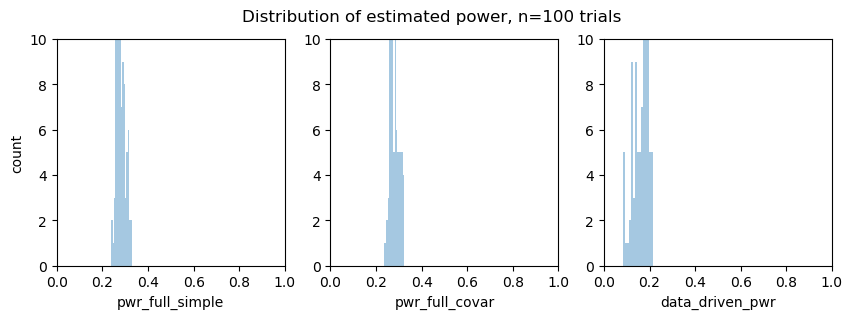

In [677]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi=100, figsize=(10,3))

sns.distplot(result_df['pwr_full_simple'], ax=ax1, kde=False, bins=15)
sns.distplot(result_df['pwr_full_covar'], ax=ax2, kde=False, bins=15)
sns.distplot(result_df['data_driven_pwr'], ax=ax3, kde=False, bins=15)
ax1.set_xlim(0,1)
ax2.set_xlim(0,1)
ax3.set_xlim(0,1)

ax1.set_ylim(0,10)
ax2.set_ylim(0,10)
ax3.set_ylim(0,10)

fig.suptitle("Distribution of estimated power, n={} trials".format(n_trials))
ax1.set_ylabel("count")

### Estimated treatment effect distributions

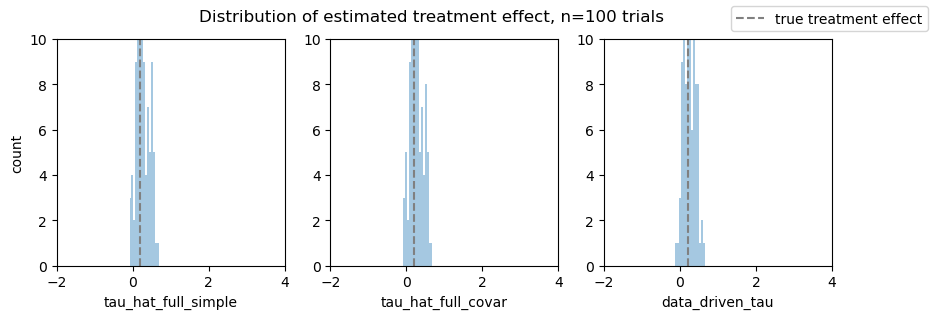

In [678]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, dpi=100, figsize=(10,3))

sns.distplot(result_df['tau_hat_full_simple'], ax=ax1, kde=False, bins=15)
sns.distplot(result_df['tau_hat_full_covar'], ax=ax2, kde=False, bins=15)
sns.distplot(result_df['data_driven_tau'], ax=ax3, kde=False, bins=15)
ax1.set_xlim(-2,4)
ax2.set_xlim(-2,4)
ax3.set_xlim(-2,4)

ax1.set_ylim(0,10)
ax2.set_ylim(0,10)
ax3.set_ylim(0,10)

ax1.axvline(x=0.2, ls='--', color="grey", label="true treatment effect")
ax2.axvline(x=0.2, ls='--', color="grey")
ax3.axvline(x=0.2, ls='--', color="grey")

fig.suptitle("Distribution of estimated treatment effect, n={} trials".format(n_trials))
ax1.set_ylabel("count")
fig.legend()

# Final graph for data-driven results

In [679]:
# load data
name_prefix = "../results/iv_data_driven_p_comply_{}.df"
gap1_df = pd.read_pickle(name_prefix.format(0.2))
gap2_df = pd.read_pickle(name_prefix.format(0.4))
gap3_df = pd.read_pickle(name_prefix.format(0.6))


In [680]:
tau = 0.25
x_var = 'Proportion compliers'

In [681]:
gap1_df[x_var] = 0.2
gap2_df[x_var] = 0.4
gap3_df[x_var] = 0.6

In [682]:
all_df = gap1_df.copy()
all_df = all_df.append(gap2_df)
all_df = all_df.append(gap3_df)

In [683]:
tau_hats = pd.melt(all_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 'data_driven_tau'])
pwrs = pd.melt(all_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 'data_driven_pwr'])
std_errs = pd.melt(all_df, id_vars=[x_var], value_vars = ['std_err_full_simple', 'std_err_full_covar', 'data_driven_std'])

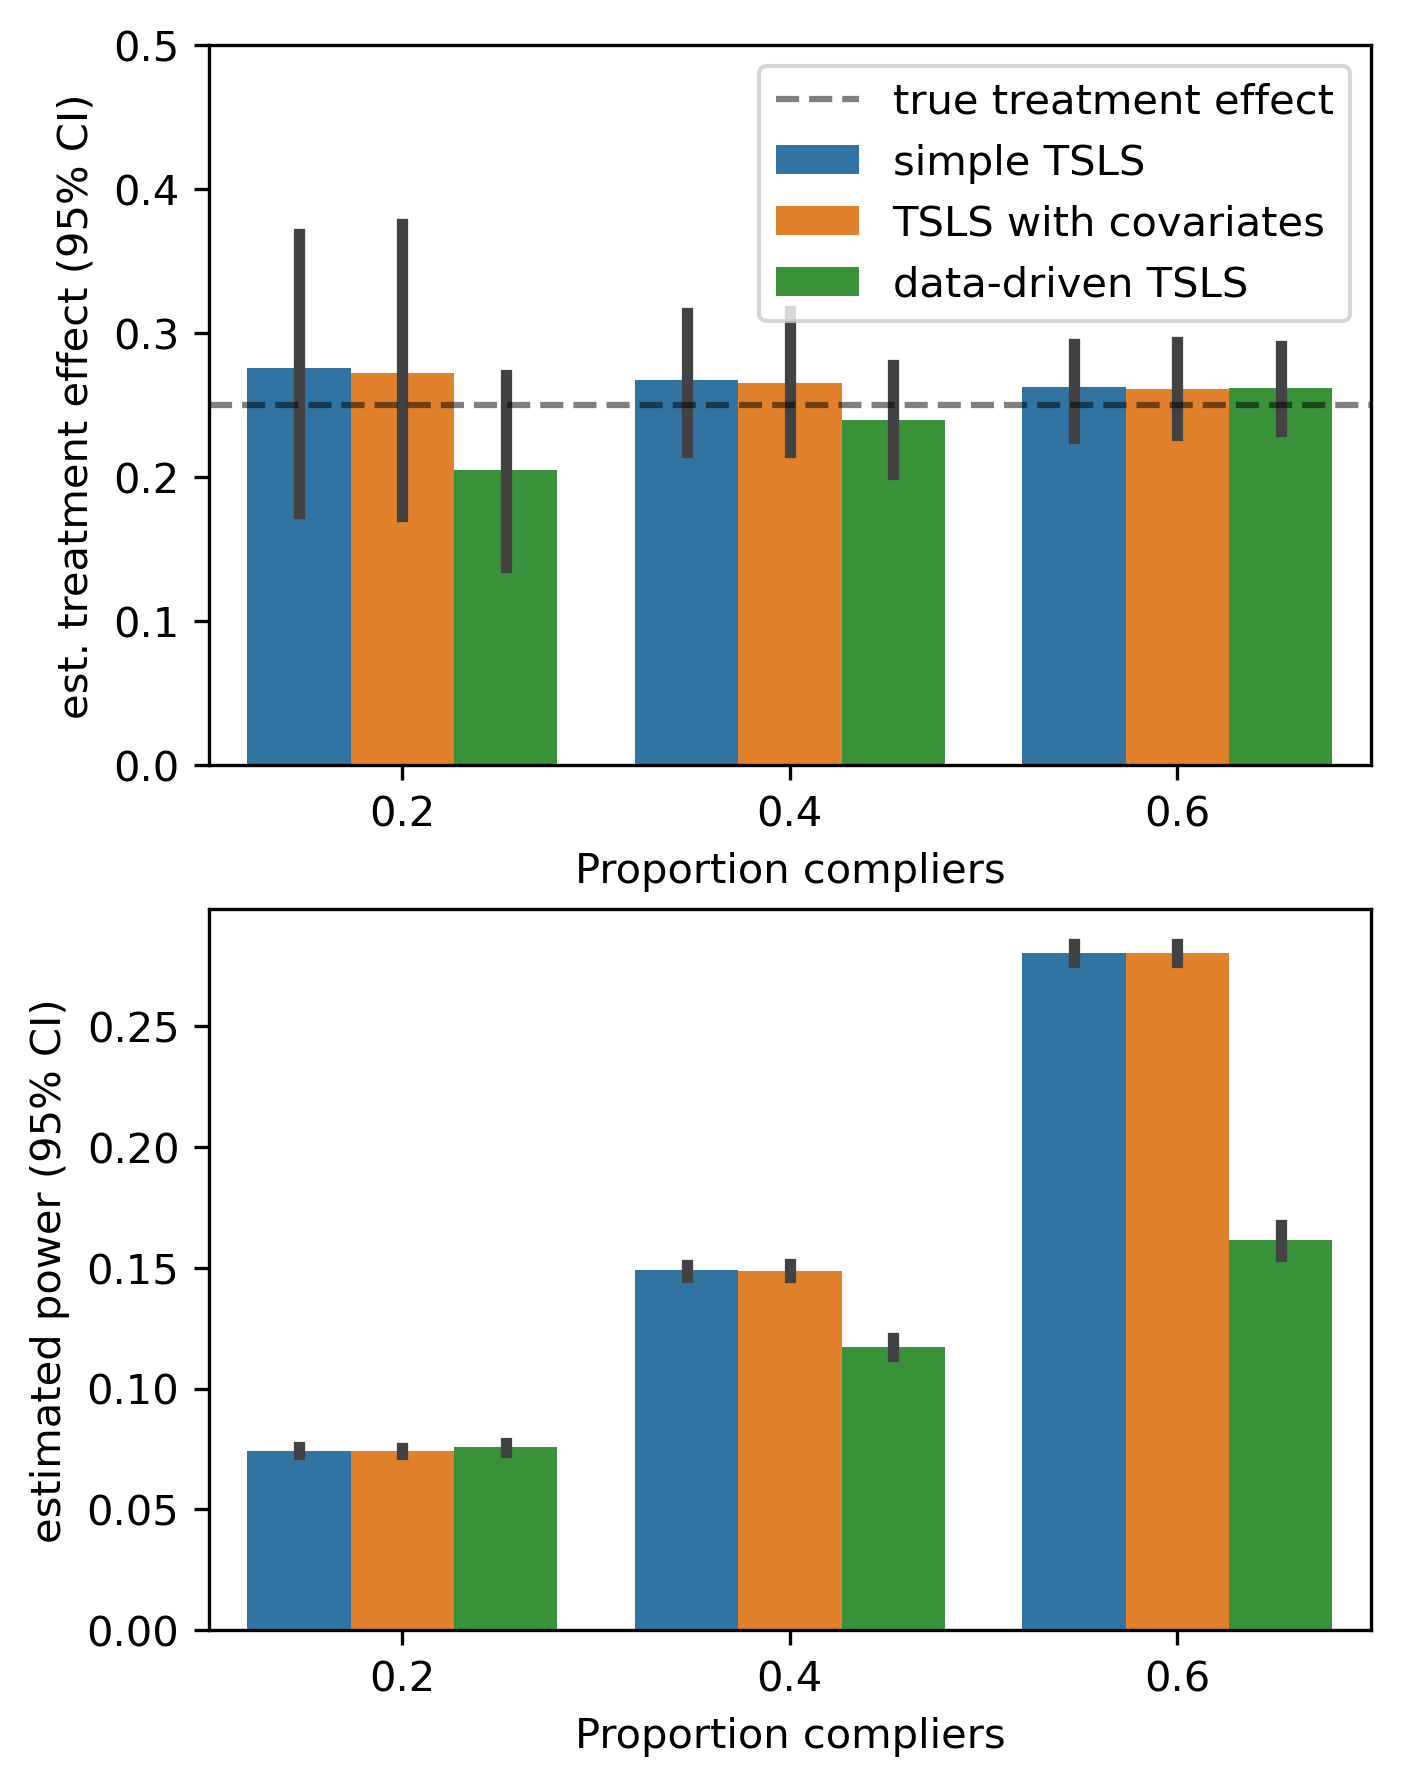

In [684]:
from numpy import median
fig, (ax1, ax2) = plt.subplots(2,1, dpi=300, figsize=(5,7))
# reproduces NACI paper figure
#fig, (ax1, ax2) = plt.subplots(1,2, dpi=100, figsize=(10,6))

sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=ax1)#, estimator=median)
ax1.axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
ax1.set_ylabel("est. treatment effect (95% CI)")
ax1.set_ylim(0,0.5)


handles, labels = ax1.get_legend_handles_labels()
new_labels = ['true treatment effect', 'simple TSLS', 'TSLS with covariates', 'data-driven TSLS']
#ax1.legend(handles, new_labels, bbox_to_anchor=(2.9,1))
ax1.legend(handles, new_labels)
#ax1.set_xlabel("Proportion compliers ")
#ax1.set_title("Treatment effect estimates")
# sns.barplot(data=std_errs, hue="variable", x='P(treat) jump', y="value", ax=ax2)
# ax2.set_ylabel("standard errors")
# ax2.get_legend().set_visible(False)

sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=ax2)#, estimator=median)
#ax2.set_title("Statistical power")
ax2.set_ylabel("estimated power (95% CI)")
ax2.get_legend().set_visible(False)
#ax2.set_xlabel("Proportion compliers (95% CI)")



# Sandbox/reference

In [ ]:
iv_model = IV2SLS.from_formula(formula, sel_df)
iv_results = iv_model.fit(cov_type='robust')
var = iv_results.std_errors['T']**2
tau_hat = iv_results.params['T']
var_list.append(var)
tau_list.append(tau_hat)

pwr = rdd_power(tau, var)
#pwr = iv_power(sel_df, tau)
complier_pwr_list.append(pwr)

In [655]:
# # alternative formulation with shared covariance
# def generate_IV(n, tau, prop_comply, seed, C_T=0.8, prop_nt=0.5, prop_z=0.5):
#     """
#     Generates IV data with compliance indicator X.
    
#     Args:
#         prop_comply (float): the *total proportion* of compliers in the data
#         C_T (float): the confounding strength between C and T
#             TODO needs to be fixed, by generating shared covariance for compliers and noncompliers
#         prop_nt (float): the proportion of never takers *among non-compliers*
        
    
#     """
#     np.random.seed(seed)

#     Z_T = 0.8

#     # vars:             Z    T    C
#     covar = np.array([[1.0, Z_T, 0.0], # Z
#                       [Z_T, 1.0, C_T], # T
#                       [0.0, C_T, 1.0]])# C
    
#     covar += np.eye(3,3)

#     # vars:  Z  T  C
#     means = [0, 0, 0]

#     # generate some data
#     data = np.random.multivariate_normal(mean=means, cov=covar, size=n)

#     # generate binary instrument
#     Z = (data[:, 0] > norm.ppf(1-prop_z)).astype(int)

#     # generate random binary covariate for compliance
#     X = np.random.random_sample(n)
#     X = (X < prop_comply).astype(int)

#     # generate endogenous treatment
#     T = (data[:, 1] > 0).astype(int)

#     # fill in Z when the sample is a complier
#     T = np.where(X == 1, Z, T)
    
#     # set never takers to prop_nt of non-compliers
#     T[X != 1] = (np.random.sample((X != 1).sum()) > prop_nt).astype(int)

#     # generate a confounder: correlation with treatment
#     # problem with this approach, creates a path T -> C -> Y
#     #     C = np.random.normal(loc=C_T * (T - np.mean(T)), 
#     #                          scale=1 - (C_T**2))
#     C = data[:, 2]
    
#     # add noncomplier bias
#     nc_bias_eff = 0.25
#     B = np.where(X != 1, nc_bias_eff, 0)

#     Y = (tau + B)*T + C + np.random.normal(0, 1, n)
    
#     df = pd.DataFrame()
#     df['Z'] = Z
#     df['X'] = X
#     df['T'] = T
#     df['C'] = C
#     df['Y'] = Y
#     df['B'] = B
    
#     return df